In [ ]:
# Install necessary libraries
!pip install prophet --upgrade

# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime as dt
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools

In [ ]:
# Load the dataset
dataset = pd.read_csv("/content/electric_consumption.csv")

# Display the first few rows
dataset.head()

<ipython-input-142-004f8cfb0555>:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("/content/electric_consumption.csv")


Development Name Borough Account Name Location Meter AMR   Meter Scope  \
0            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
1            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
2            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
3            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   
4            ADAMS   BRONX        ADAMS   BLD 05      NONE  BLD 01 to 07   

   TDS #  EDP  RC Code Funding Source  ... Meter Number Estimated  \
0  118.0  248  B011800        FEDERAL  ...      7223256         N   
1  118.0  248  B011800        FEDERAL  ...      7223256         N   
2  118.0  248  B011800        FEDERAL  ...      7223256         N   
3  118.0  248  B011800        FEDERAL  ...      7223256         N   
4  118.0  248  B011800        FEDERAL  ...      7223256         N   

   Current Charges   Rate Class Bill Analyzed Consumption (KWH)  KWH Charges  \
0         15396.82  GOV/NYC/068           Yes          128800.0      7387.97   
1         14556.34  GOV/NYC/068           Yes          115200.0      6607.87   
2         13904.98  GOV/NYC/068           Yes          103200.0      5919.55   
3         14764.04  GOV/NYC/068           Yes          105600.0      6057.22   
4         13729.54  GOV/NYC/068           Yes           97600.0      5598.34   

  Consumption (KW) KW Charges  Other charges  
0            216.0     2808.0        5200.85  
1            224.0     2912.0        5036.47  
2            216.0     2808.0        5177.43  
3            208.0     2704.0        6002.82  
4            216.0     2808.0        5323.20  

[5 rows x 27 columns]

In [ ]:
# Describe the target variable
print(dataset['Consumption (KWH)'].describe())

# Check dataset dimensions
print(dataset.shape)

# Check for missing values
print(dataset.isnull().sum())

count    4.478490e+05
mean     3.115645e+04
std      4.896050e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.340000e+04
75%      4.608000e+04
max      1.779600e+06
Name: Consumption (KWH), dtype: float64
(447849, 27)
Development Name        1481
Borough                    0
Account Name               0
Location               11721
Meter AMR                227
Meter Scope           423982
TDS #                   2738
EDP                        0
RC Code                    0
Funding Source             0
AMP #                   1887
Vendor Name                0
UMIS BILL ID               0
Revenue Month              0
Service Start Date         8
Service End Date           8
# days                     8
Meter Number               0
Estimated                342
Current Charges            0
Rate Class                 0
Bill Analyzed              0
Consumption (KWH)          0
KWH Charges                0
Consumption (KW)           0
KW Charges                 0
Other charges    

In [ ]:
# Drop missing values
data_cleaned = dataset.dropna()

# Verify no missing values
print(data_cleaned.isnull().sum())

# Check updated shape
print(data_cleaned.shape)

Development Name      0
Borough               0
Account Name          0
Location              0
Meter AMR             0
Meter Scope           0
TDS #                 0
EDP                   0
RC Code               0
Funding Source        0
AMP #                 0
Vendor Name           0
UMIS BILL ID          0
Revenue Month         0
Service Start Date    0
Service End Date      0
# days                0
Meter Number          0
Estimated             0
Current Charges       0
Rate Class            0
Bill Analyzed         0
Consumption (KWH)     0
KWH Charges           0
Consumption (KW)      0
KW Charges            0
Other charges         0
dtype: int64
(23268, 27)


In [ ]:
# Convert 'Service Start Date' to datetime
data_cleaned['Service Start Date'] = pd.to_datetime(data_cleaned['Service Start Date'])

# Rename columns for compatibility with Prophet
data_cleaned = data_cleaned.rename(columns={'Service Start Date':'date', 'Consumption (KWH)':'consumption'})

# Extract year, month, and day
data_cleaned['year'] = data_cleaned['date'].dt.year
data_cleaned['month'] = data_cleaned['date'].dt.month
data_cleaned['day'] = data_cleaned['date'].dt.day

<ipython-input-145-8ecb12e80211>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Service Start Date'] = pd.to_datetime(data_cleaned['Service Start Date'])


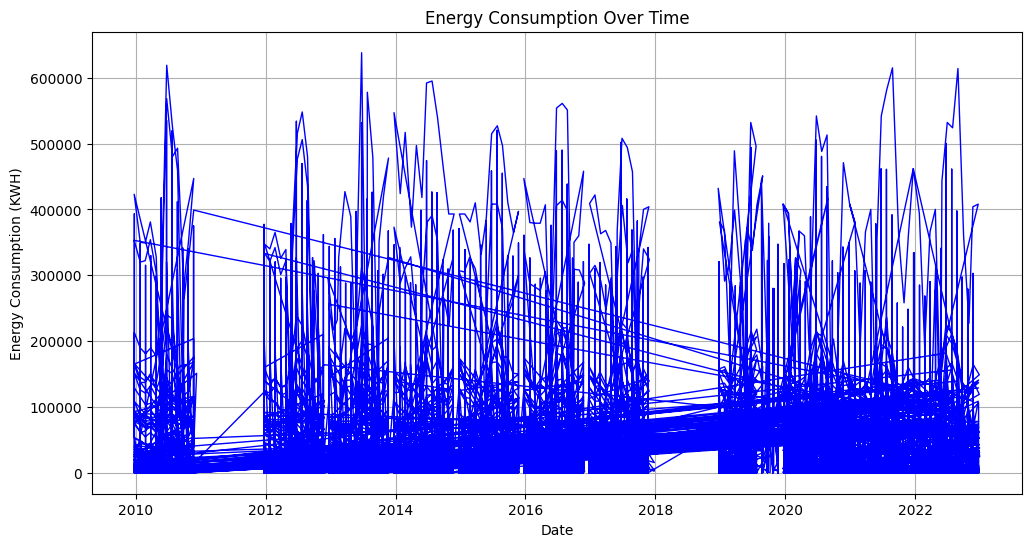

In [ ]:
# Plot consumption over time using a line plot
plt.figure(figsize=(12, 6))
plt.plot(data_cleaned['date'], data_cleaned['consumption'], color='blue', linewidth=1)
plt.title("Energy Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (KWH)")
plt.grid(True)  # Adds a grid for better readability
plt.show()

In [ ]:
# Create a copy for transformations
data_transformed = data_cleaned.copy()

# Calculate averages for year, month, and day
data_transformed['yearly_avg'] = data_transformed.groupby('year')['consumption'].transform('mean')
data_transformed['monthly_avg'] = data_transformed.groupby(['year', 'month'])['consumption'].transform('mean')
data_transformed['daily_avg'] = data_transformed.groupby(['year', 'month', 'day'])['consumption'].transform('mean')

# Select relevant columns
data_transformed = data_transformed[['date', 'yearly_avg', 'monthly_avg', 'daily_avg', 'Borough']]

In [ ]:
# Summary statistics
print(data_transformed.describe())

# Preview the tail of the transformed dataset
data_transformed.tail()

                                date    yearly_avg    monthly_avg  \
count                          23268  23268.000000   23268.000000   
mean   2017-01-25 22:27:39.824652032  22910.772563   22910.772563   
min              2009-12-23 00:00:00  21836.910828    7746.666667   
25%              2013-12-27 00:00:00  22191.896926   19792.551282   
50%              2016-11-22 00:00:00  22907.386002   21490.343195   
75%              2020-06-22 00:00:00  24016.999513   24378.397590   
max              2022-12-29 00:00:00  24031.368062  150980.000000   
std                              NaN    778.983016    4221.607548   

           daily_avg  
count   23268.000000  
mean    22910.772563  
min         0.000000  
25%     14352.350000  
50%     16190.913333  
75%     20134.326923  
max    614000.000000  
std     27871.109160  


date    yearly_avg   monthly_avg     daily_avg   Borough
447142 2022-08-23  22506.192571  27449.438596  20797.723684  BROOKLYN
447143 2022-09-22  22506.192571  19308.971751  14786.543046  BROOKLYN
447144 2022-10-24  22506.192571  18686.807018  13120.027211  BROOKLYN
447145 2022-11-22  22506.192571  21233.802395  14353.368056  BROOKLYN
447146 2022-12-23  22506.192571  20316.486667  12169.785714  BROOKLYN

In [ ]:
# Prepare datasets for yearly, monthly, and daily averages
data_yearly = data_transformed.rename(columns={'yearly_avg': 'consumption'})[['date', 'consumption', 'Borough']].dropna().reset_index(drop=True)
data_monthly = data_transformed.rename(columns={'monthly_avg': 'consumption'})[['date', 'consumption', 'Borough']].dropna().reset_index(drop=True)
data_daily = data_transformed.rename(columns={'daily_avg': 'consumption'})[['date', 'consumption', 'Borough']].dropna().reset_index(drop=True)

In [ ]:
# Check the tail of the yearly dataset
print(data_yearly.tail())

# Describe consumption for each dataset
print(data_yearly['consumption'].describe())
print(data_monthly['consumption'].describe())
print(data_daily['consumption'].describe())

            date   consumption   Borough
23263 2022-08-23  22506.192571  BROOKLYN
23264 2022-09-22  22506.192571  BROOKLYN
23265 2022-10-24  22506.192571  BROOKLYN
23266 2022-11-22  22506.192571  BROOKLYN
23267 2022-12-23  22506.192571  BROOKLYN
count    23268.000000
mean     22910.772563
std        778.983016
min      21836.910828
25%      22191.896926
50%      22907.386002
75%      24016.999513
max      24031.368062
Name: consumption, dtype: float64
count     23268.000000
mean      22910.772563
std        4221.607548
min        7746.666667
25%       19792.551282
50%       21490.343195
75%       24378.397590
max      150980.000000
Name: consumption, dtype: float64
count     23268.000000
mean      22910.772563
std       27871.109160
min           0.000000
25%       14352.350000
50%       16190.913333
75%       20134.326923
max      614000.000000
Name: consumption, dtype: float64


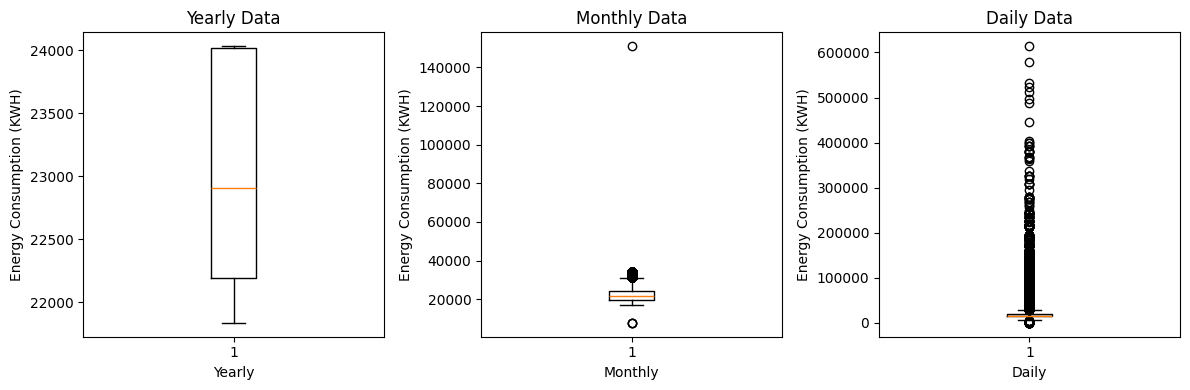

In [ ]:
import matplotlib.pyplot as plt

# Create separate box plots for yearly, monthly, and daily data
plt.figure(figsize=(12, 4))

# Yearly data
plt.subplot(1, 3, 1)
plt.boxplot(data_yearly['consumption'])
plt.title('Yearly Data')
plt.xlabel('Yearly')
plt.ylabel('Energy Consumption (KWH)')

# Monthly data
plt.subplot(1, 3, 2)
plt.boxplot(data_monthly['consumption'])
plt.title('Monthly Data')
plt.xlabel('Monthly')
plt.ylabel('Energy Consumption (KWH)')

# Daily data
plt.subplot(1, 3, 3)
plt.boxplot(data_daily['consumption'])
plt.title('Daily Data')
plt.xlabel('Daily')
plt.ylabel('Energy Consumption (KWH)')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
def remove_outliers_iqr(dataframe, column):
    """
    Removes extreme outliers using the IQR method.
    """
    Q1 = dataframe[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = dataframe[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers

    # Filter data within the bounds
    filtered_df = dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]
    return filtered_df

# Remove outliers from the data_daily dataset
data_daily_filtered = remove_outliers_iqr(data_daily, 'consumption')

# Check the shape of the dataset after outlier removal
print(f"Original daily dataset shape: {data_daily.shape}")
print(f"Filtered daily dataset shape: {data_daily_filtered.shape}")

Original daily dataset shape: (23268, 3)
Filtered daily dataset shape: (21103, 3)


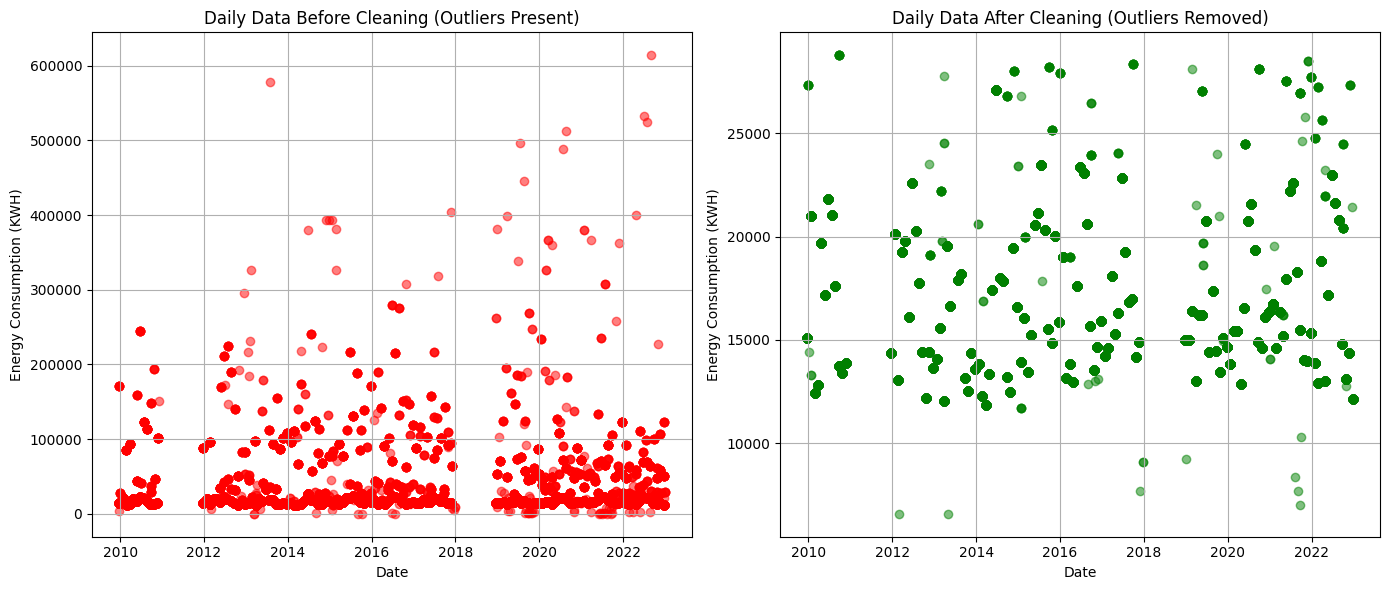

In [ ]:
# Plot the data before and after cleaning
plt.figure(figsize=(14, 6))

# Before cleaning
plt.subplot(1, 2, 1)
plt.scatter(data_daily['date'], data_daily['consumption'], color='red', alpha=0.5)
plt.title("Daily Data Before Cleaning (Outliers Present)")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (KWH)")
plt.grid(True)

# After cleaning
plt.subplot(1, 2, 2)
plt.scatter(data_daily_filtered['date'], data_daily_filtered['consumption'], color='green', alpha=0.5)
plt.title("Daily Data After Cleaning (Outliers Removed)")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (KWH)")
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Aggregate daily data to calculate monthly mean
data_monthly = data_daily_filtered.copy()
data_monthly['month'] = data_monthly['date'].dt.to_period('M')  # Extract year-month
data_monthly = data_monthly.groupby('month').agg({'consumption': 'mean'}).reset_index()

# Rename columns for consistency
data_monthly = data_monthly.rename(columns={'month': 'ds', 'consumption': 'y'})

# Convert 'ds' back to datetime for compatibility with Prophet
data_monthly['ds'] = data_monthly['ds'].dt.to_timestamp()

# Check the monthly dataset
data_monthly.head()

ds             y
0 2009-12-01  15693.408163
1 2010-01-01  20862.031847
2 2010-02-01  12432.314286
3 2010-03-01  12844.328571
4 2010-04-01  19663.532051

In [ ]:
# Aggregate daily data to calculate yearly mean
data_yearly = data_daily_filtered.copy()
data_yearly['year'] = data_yearly['date'].dt.to_period('Y')  # Extract year
data_yearly = data_yearly.groupby('year').agg({'consumption': 'mean'}).reset_index()

# Rename columns for consistency
data_yearly = data_yearly.rename(columns={'year': 'ds', 'consumption': 'y'})

# Convert 'ds' back to datetime for compatibility with Prophet
data_yearly['ds'] = data_yearly['ds'].dt.to_timestamp()

# Check the yearly dataset
data_yearly.head()

ds             y
0 2009-01-01  15693.408163
1 2010-01-01  16904.168242
2 2011-01-01  14366.489362
3 2012-01-01  17055.494822
4 2013-01-01  15341.840635

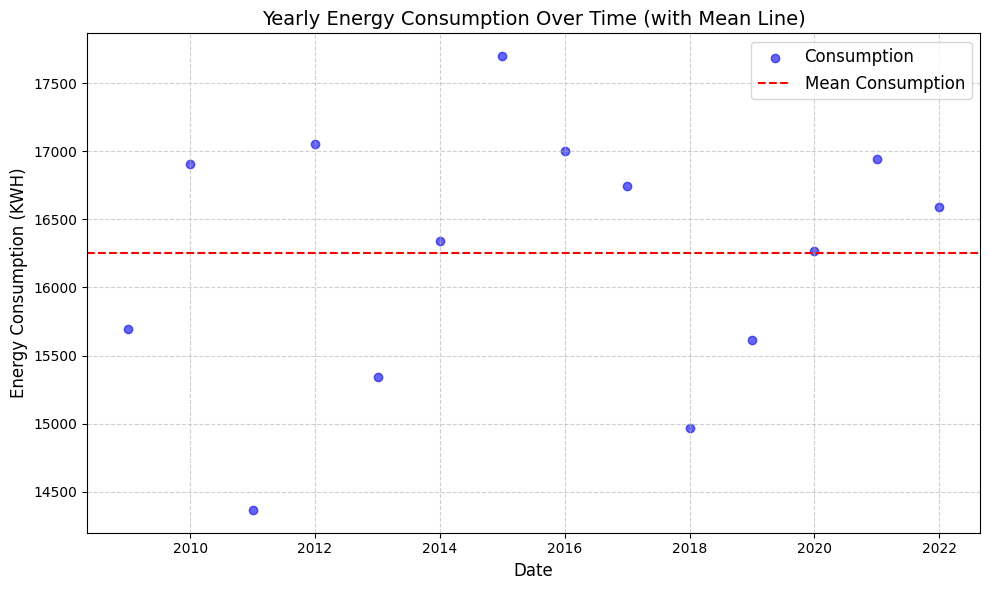

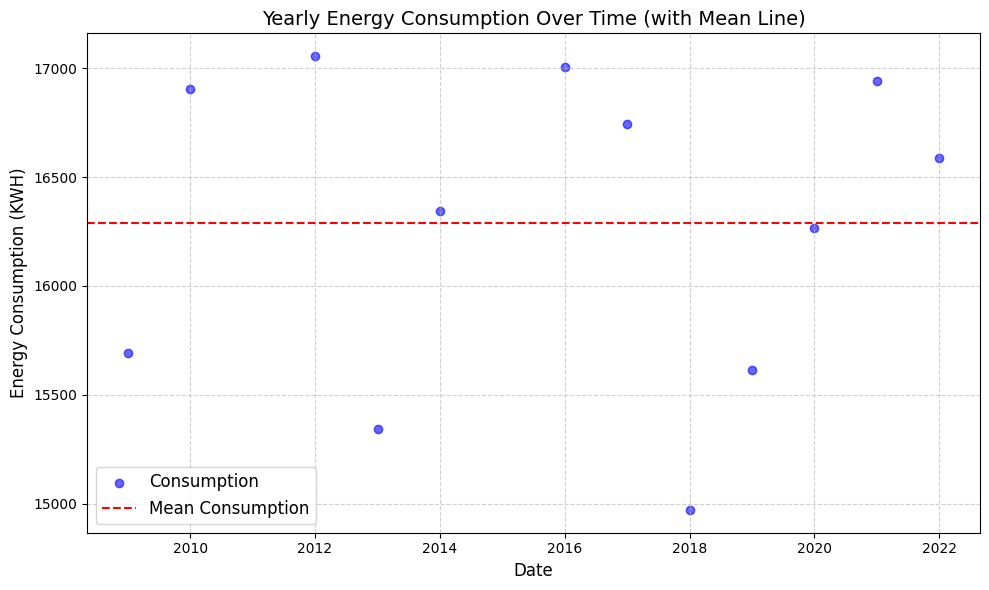

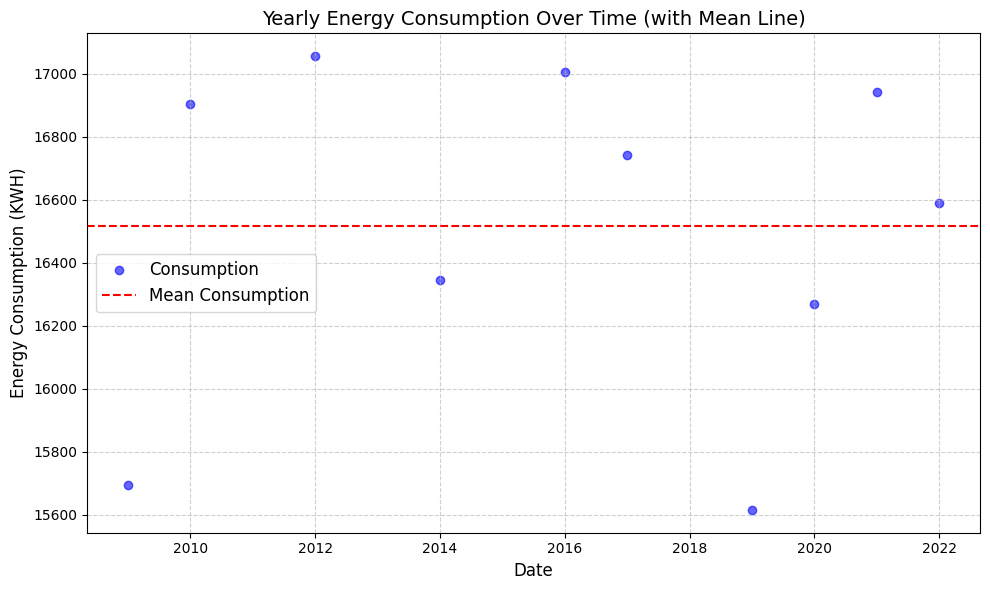

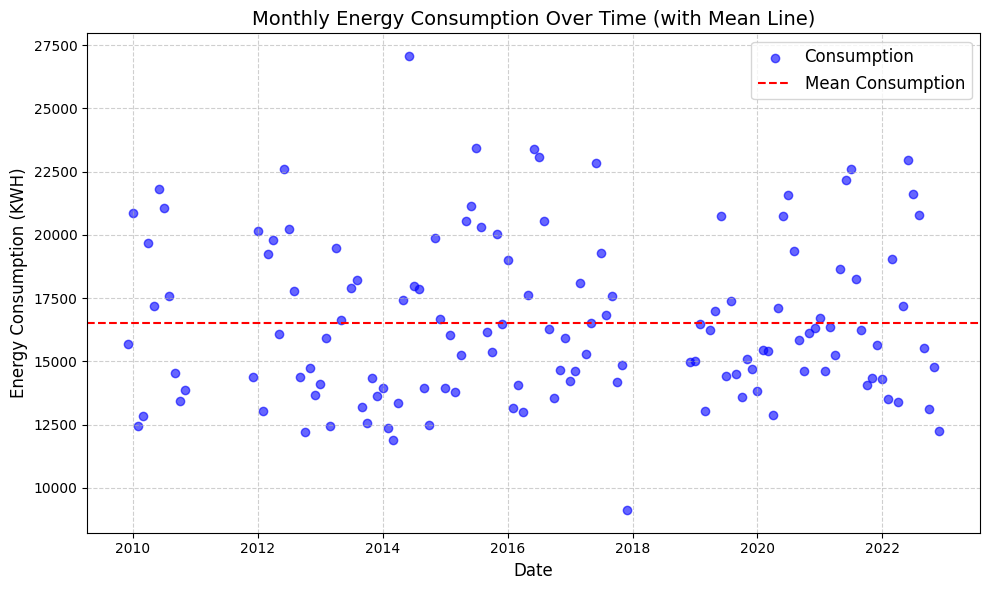

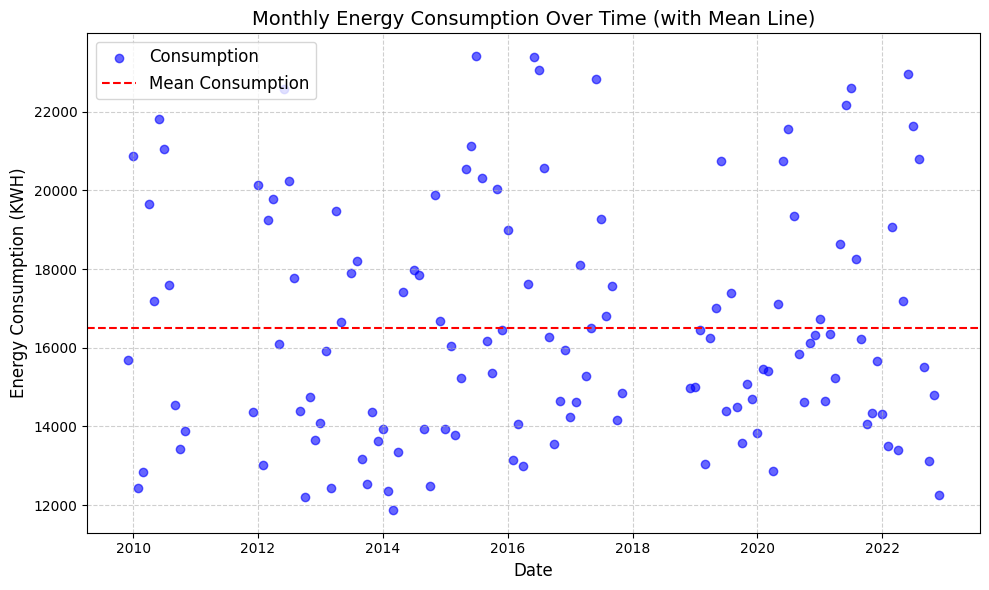

In [ ]:
# Define a function to plot the data and its mean
def plot_data_check(df, dataset_type):
    """
    Plots the data with a scatter plot and a mean line.
    Args:
    - df: DataFrame containing the data to plot.
    - dataset_type: String indicating the dataset type (e.g., "Yearly", "Monthly").
    """
    plt.figure(figsize=(10, 6))  # Set figure size for better readability
    plt.scatter(df['ds'], df['y'], color='blue', alpha=0.6, label="Consumption")
    plt.axhline(df['y'].mean(), color="red", linestyle="--", label="Mean Consumption")

    # Add title and labels
    plt.title(f"{dataset_type} Energy Consumption Over Time (with Mean Line)", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Energy Consumption (KWH)", fontsize=12)

    # Add grid and legend
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot and modify yearly data
# Initial plot to visualize the dataset
plot_data_check(data_yearly, "Yearly")

# Remove extreme outliers from the yearly data
data_yearly = data_yearly.drop(index=[data_yearly[data_yearly['y'] == data_yearly['y'].min()].index[0]], axis=0)
data_yearly = data_yearly.drop(index=[data_yearly[data_yearly['y'] == data_yearly['y'].max()].index[0]], axis=0)

# Plot again after outlier removal
plot_data_check(data_yearly, "Yearly")

# Further refine by removing additional outliers
data_yearly = data_yearly.drop(index=[data_yearly[data_yearly['y'] == data_yearly['y'].min()].index[0]], axis=0)
data_yearly = data_yearly.drop(index=[data_yearly[data_yearly['y'] == data_yearly['y'].min()].index[0]], axis=0)

# Plot again after further cleaning
plot_data_check(data_yearly, "Yearly")

# Plot and modify monthly data
# Initial plot to visualize the dataset
plot_data_check(data_monthly, "Monthly")

# Remove extreme outliers from the monthly data
data_monthly = data_monthly.drop(index=[data_monthly[data_monthly['y'] == data_monthly['y'].max()].index[0]], axis=0)
data_monthly = data_monthly.drop(index=[data_monthly[data_monthly['y'] == data_monthly['y'].min()].index[0]], axis=0)

# Plot again after outlier removal
plot_data_check(data_monthly, "Monthly")

In [ ]:
# Rename columns for Prophet compatibility
data_daily_filtered = data_daily_filtered.rename(columns={'date': 'ds', 'consumption': 'y'})

# Ensure 'ds' is in datetime format
data_daily_filtered['ds'] = pd.to_datetime(data_daily_filtered['ds'])

# Ensure 'y' is numeric
data_daily_filtered['y'] = pd.to_numeric(data_daily_filtered['y'], errors='coerce')

# Drop rows with NaN values
data_daily_filtered = data_daily_filtered.dropna()

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

def train_and_forecast(df, periods, title):

    # Train Prophet model
    model = Prophet()
    model.fit(df)

    # Create future DataFrame and make predictions
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['y'], label="Actual Data", color="blue", alpha=0.6)
    plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="green", linewidth=2)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color="gray", alpha=0.2, label="Confidence Interval")
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Energy Consumption (KWH)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return forecast

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/51ap0mai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/4opldw5u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69641', 'data', 'file=/tmp/tmpkr712cnu/51ap0mai.json', 'init=/tmp/tmpkr712cnu/4opldw5u.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelaggla1j1/prophet_model-20241211003658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:37:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


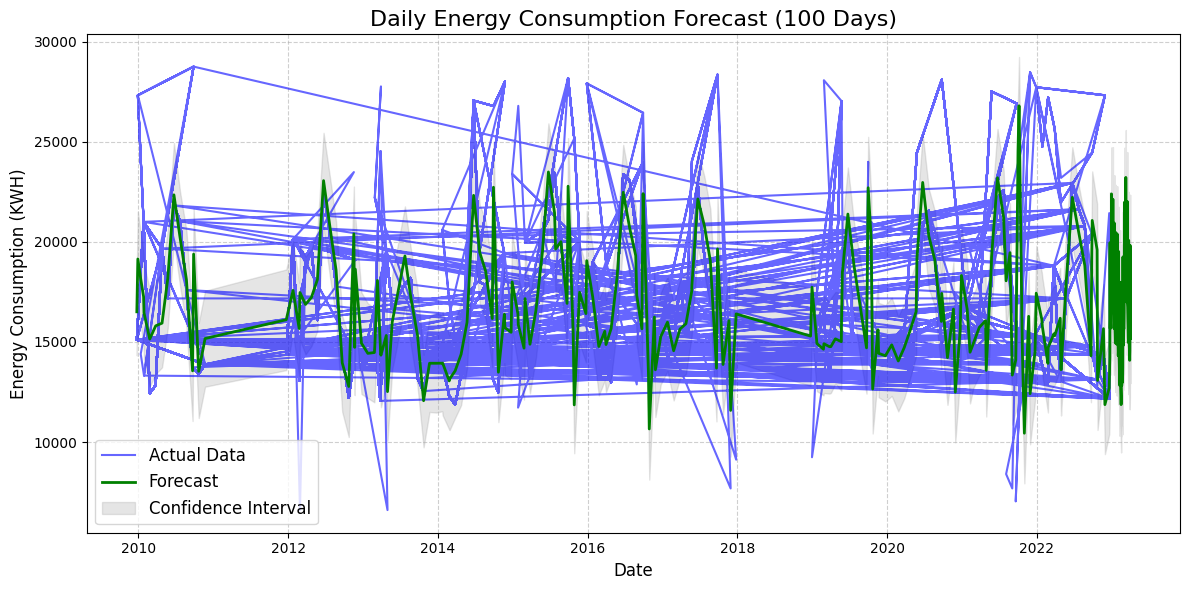

Head of 100 Days Forecast:
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-24  16507.618718  14323.737573  18785.011359
1 2009-12-29  19148.150692  16722.881351  21515.695603
2 2010-01-12  18151.356107  15884.517892  20471.960364
3 2010-01-26  17260.901664  14764.117721  19462.876090
4 2010-01-28  16454.997555  14123.353707  18881.445288

Tail of 100 Days Forecast:
            ds          yhat    yhat_lower    yhat_upper
296 2023-03-29  14486.016689  11894.254038  16955.794423
297 2023-03-30  14082.183200  11635.331511  16419.188399
298 2023-03-31  14569.414724  12236.528104  17091.145137
299 2023-04-01  19827.652355  17283.679195  22361.291274
300 2023-04-02  15171.174258  12938.823594  17722.540107


In [ ]:
# Drop unnecessary columns
data_daily_filtered = data_daily_filtered[['ds', 'y']]

# Generate the forecast for 100 days again
forecast_100_days = train_and_forecast(data_daily_filtered, periods=100, title="Daily Energy Consumption Forecast (100 Days)")

# Display the head and tail of the forecast
print("Head of 100 Days Forecast:")
print(forecast_100_days[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nTail of 100 Days Forecast:")
print(forecast_100_days[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/99s8d9kx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/b6frionb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61271', 'data', 'file=/tmp/tmpkr712cnu/99s8d9kx.json', 'init=/tmp/tmpkr712cnu/b6frionb.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_model38ukqoum/prophet_model-20241211003724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:37:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:37:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


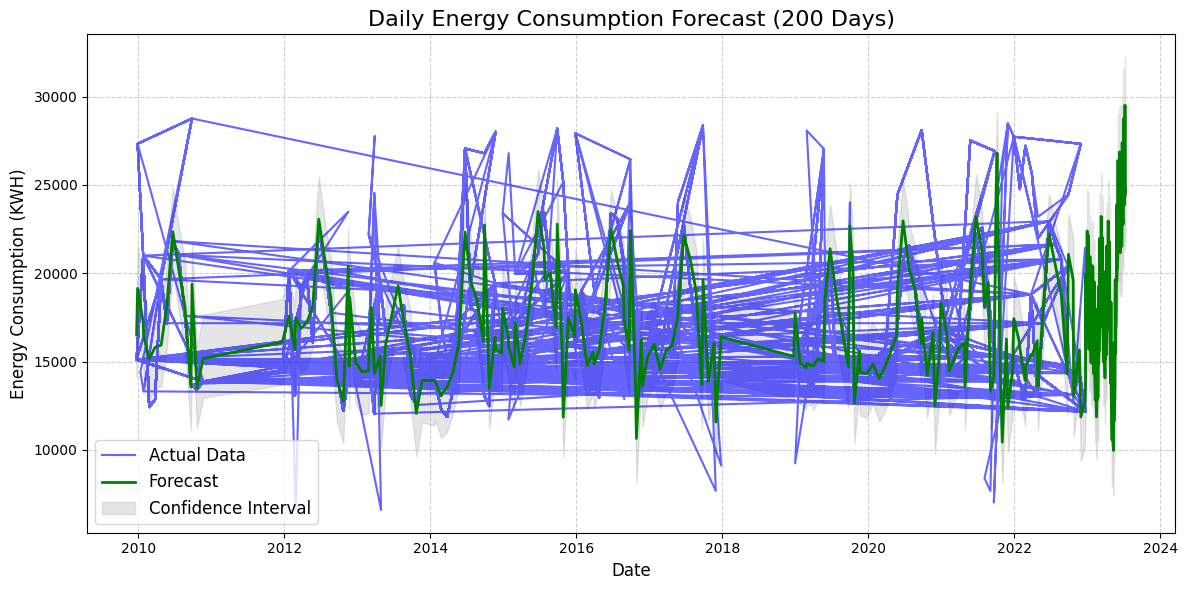

Head of 200 Days Forecast:
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-24  16507.618718  14135.067790  18836.034048
1 2009-12-29  19148.150692  16717.973924  21507.492702
2 2010-01-12  18151.356107  15637.127024  20650.935402
3 2010-01-26  17260.901664  14876.887982  19697.800598
4 2010-01-28  16454.997555  14111.136157  18900.028487

Tail of 200 Days Forecast:
            ds          yhat    yhat_lower    yhat_upper
396 2023-07-07  24350.936868  21564.989373  26992.500119
397 2023-07-08  29515.608214  26901.141631  32242.182457
398 2023-07-09  24681.879610  22014.364755  27539.050554
399 2023-07-10  24768.552377  22231.354603  27374.009077
400 2023-07-11  24484.196773  21812.152698  26876.764697


In [ ]:
# Forecast for 200 days
forecast_200_days = train_and_forecast(data_daily_filtered, periods=200, title="Daily Energy Consumption Forecast (200 Days)")

# Display the head and tail of the forecast for 200 days
print("Head of 200 Days Forecast:")
print(forecast_200_days[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nTail of 200 Days Forecast:")
print(forecast_200_days[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/4d1gby_h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/z77zn2bf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77936', 'data', 'file=/tmp/tmpkr712cnu/4d1gby_h.json', 'init=/tmp/tmpkr712cnu/z77zn2bf.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelfqsvqoa7/prophet_model-20241211003749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:37:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


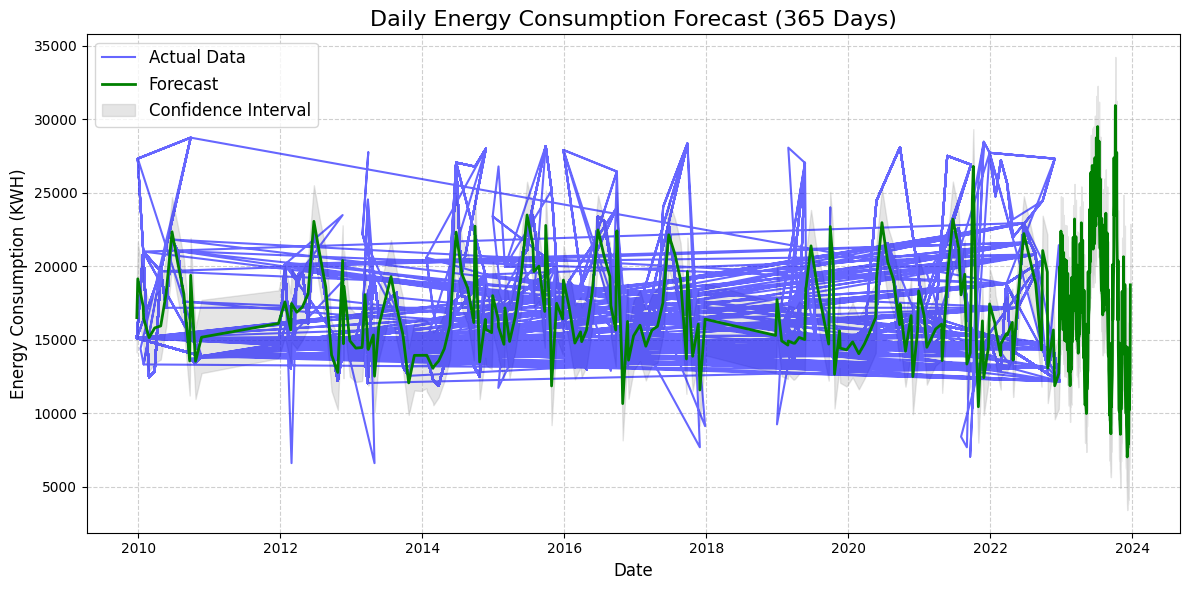

Head of 365 Days Forecast:
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-24  16507.618718  14136.060805  18850.666223
1 2009-12-29  19148.150692  16807.727158  21638.881152
2 2010-01-12  18151.356107  15768.121530  20443.435678
3 2010-01-26  17260.901664  14884.381217  19770.585166
4 2010-01-28  16454.997555  13904.518139  18768.559915

Tail of 365 Days Forecast:
            ds          yhat    yhat_lower    yhat_upper
561 2023-12-19  11387.943654   7455.182756  15344.094790
562 2023-12-20  11721.216808   7882.620143  15695.063212
563 2023-12-21  11940.095936   7950.643124  16224.891259
564 2023-12-22  12988.261997   9196.078332  17117.874569
565 2023-12-23  18736.638275  14923.893297  22884.702219


In [ ]:
# Forecast for 365 days
forecast_365_days = train_and_forecast(data_daily_filtered, periods=365, title="Daily Energy Consumption Forecast (365 Days)")

# Display the head and tail of the forecast for 365 days
print("Head of 365 Days Forecast:")
print(forecast_365_days[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nTail of 365 Days Forecast:")
print(forecast_365_days[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [ ]:
# Rename columns for Prophet compatibility
data_monthly = data_monthly.rename(columns={'date': 'ds', 'consumption': 'y'})

# Ensure 'ds' is in datetime format
data_monthly['ds'] = pd.to_datetime(data_monthly['ds'])

# Ensure 'y' is numeric
data_monthly['y'] = pd.to_numeric(data_monthly['y'], errors='coerce')

# Drop rows with NaN values
data_monthly = data_monthly.dropna()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/4f7nmjd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/p2kivwd1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66919', 'data', 'file=/tmp/tmpkr712cnu/4f7nmjd9.json', 'init=/tmp/tmpkr712cnu/p2kivwd1.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelr8o64ja3/prophet_model-20241211003812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:38:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

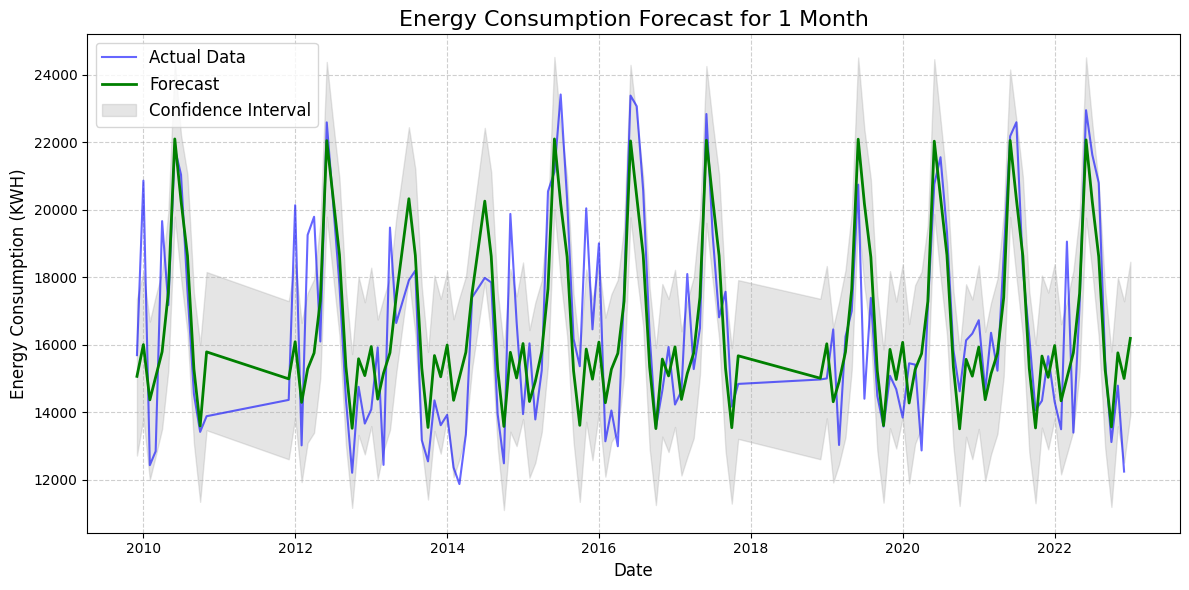

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/29x8bylv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/m1cc6y39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52732', 'data', 'file=/tmp/tmpkr712cnu/29x8bylv.json', 'init=/tmp/tmpkr712cnu/m1cc6y39.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelvnleg4hc/prophet_model-20241211003813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:38:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

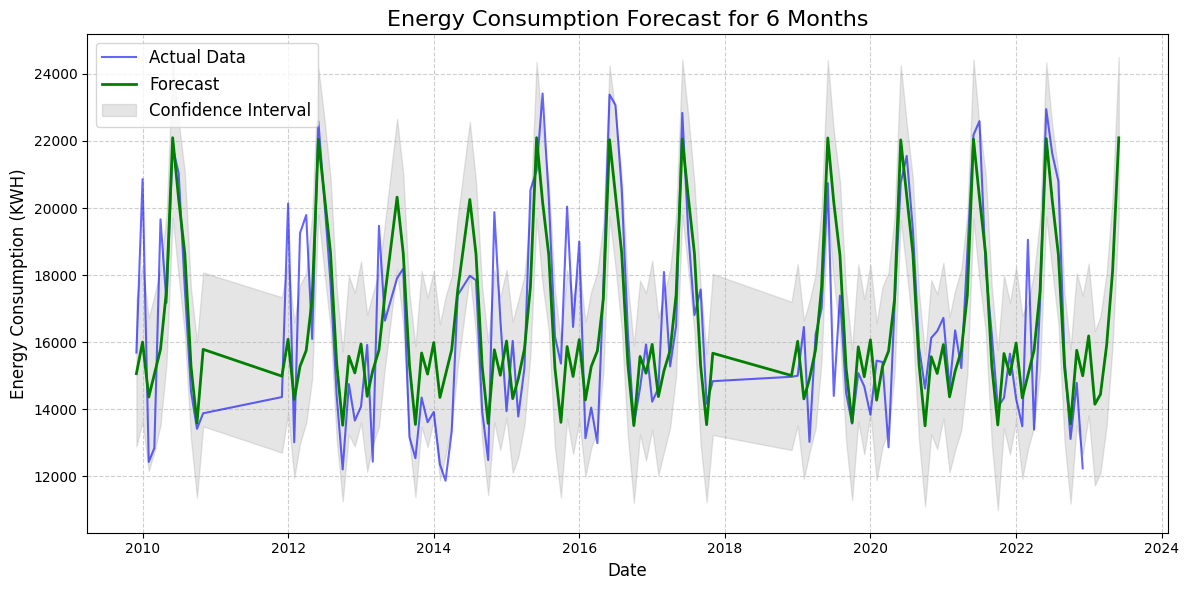

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/9or6kjyh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/kko9f7v3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59255', 'data', 'file=/tmp/tmpkr712cnu/9or6kjyh.json', 'init=/tmp/tmpkr712cnu/kko9f7v3.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_model15ktilo2/prophet_model-20241211003814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:38:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

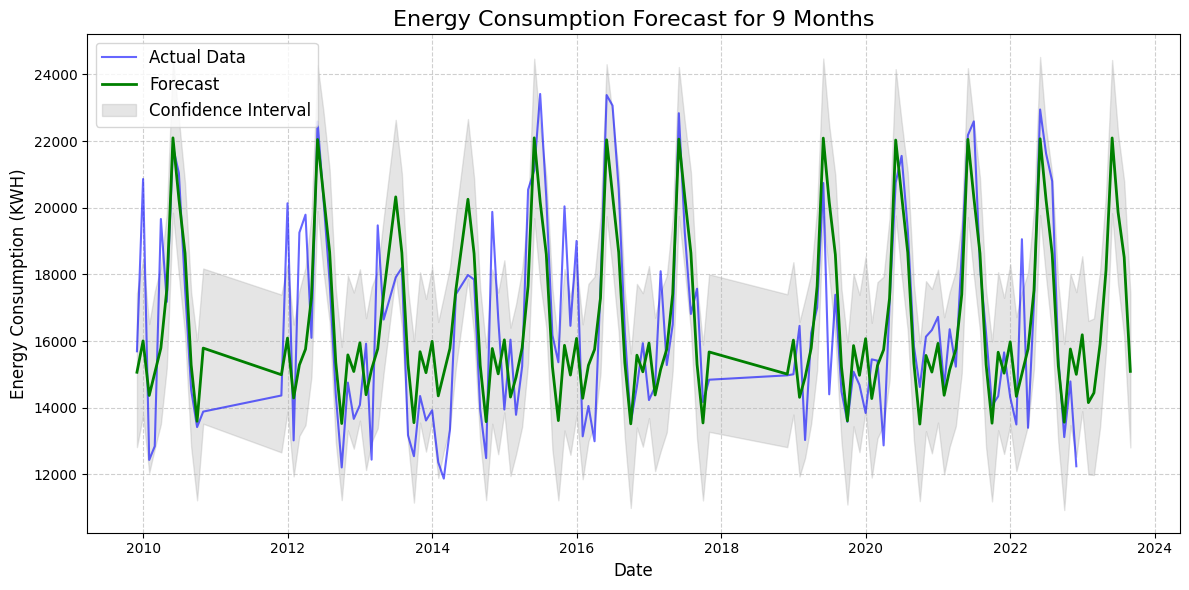


Head of 1 Month Forecast:
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-01  15064.206993  12717.694009  17366.781989
1 2010-01-01  16005.524511  13824.064957  18142.610898
2 2010-02-01  14367.686611  12000.232892  16687.857424
3 2010-03-01  15046.683083  12699.220536  17429.086471
4 2010-04-01  15791.736807  13504.251539  18156.857073

Tail of 1 Month Forecast:
            ds          yhat    yhat_lower    yhat_upper
127 2022-09-01  15255.140134  12942.675107  17627.463690
128 2022-10-01  13564.785897  11193.671207  15798.071590
129 2022-11-01  15761.628880  13585.916394  17995.139143
130 2022-12-01  15000.754695  12510.809022  17289.390974
131 2022-12-31  16188.876447  13929.363079  18460.139471

Head of 6 Months Forecast:
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-01  15064.206993  12894.352706  17268.458293
1 2010-01-01  16005.524511  13635.707737  18285.786057
2 2010-02-01  14367.686611  12161.472469  16720.116806
3 2010-03-01  15046.683083

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

def train_and_forecast_monthly(df, periods, title):

    # Train Prophet model
    model = Prophet()
    model.fit(df)

    # Create future DataFrame and make predictions
    future = model.make_future_dataframe(periods=periods, freq='M')
    forecast = model.predict(future)

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['y'], label="Actual Data", color="blue", alpha=0.6)
    plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="green", linewidth=2)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color="gray", alpha=0.2, label="Confidence Interval")
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Energy Consumption (KWH)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return forecast

# Forecast for 1 month
forecast_1_month = train_and_forecast_monthly(data_monthly, periods=1, title="Energy Consumption Forecast for 1 Month")

# Forecast for 6 months
forecast_6_months = train_and_forecast_monthly(data_monthly, periods=6, title="Energy Consumption Forecast for 6 Months")

# Forecast for 9 months
forecast_9_months = train_and_forecast_monthly(data_monthly, periods=9, title="Energy Consumption Forecast for 9 Months")

# Display head and tail for 1 month forecast
print("\nHead of 1 Month Forecast:")
print(forecast_1_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nTail of 1 Month Forecast:")
print(forecast_1_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Display head and tail for 6 months forecast
print("\nHead of 6 Months Forecast:")
print(forecast_6_months[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nTail of 6 Months Forecast:")
print(forecast_6_months[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Display head and tail for 9 months forecast
print("\nHead of 9 Months Forecast:")
print(forecast_9_months[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nTail of 9 Months Forecast:")
print(forecast_9_months[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [ ]:
# Rename columns for Prophet compatibility
data_yearly = data_yearly.rename(columns={'date': 'ds', 'consumption': 'y'})

# Ensure 'ds' is in datetime format
data_yearly['ds'] = pd.to_datetime(data_yearly['ds'])

# Ensure 'y' is numeric
data_yearly['y'] = pd.to_numeric(data_yearly['y'], errors='coerce')

# Drop rows with NaN values
data_yearly = data_yearly.dropna()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/ieeh_71h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/9zo2vb0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63142', 'data', 'file=/tmp/tmpkr712cnu/ieeh_71h.json', 'init=/tmp/tmpkr712cnu/9zo2vb0k.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modele9cr41tu/prophet_model-20241211003814.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:38:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

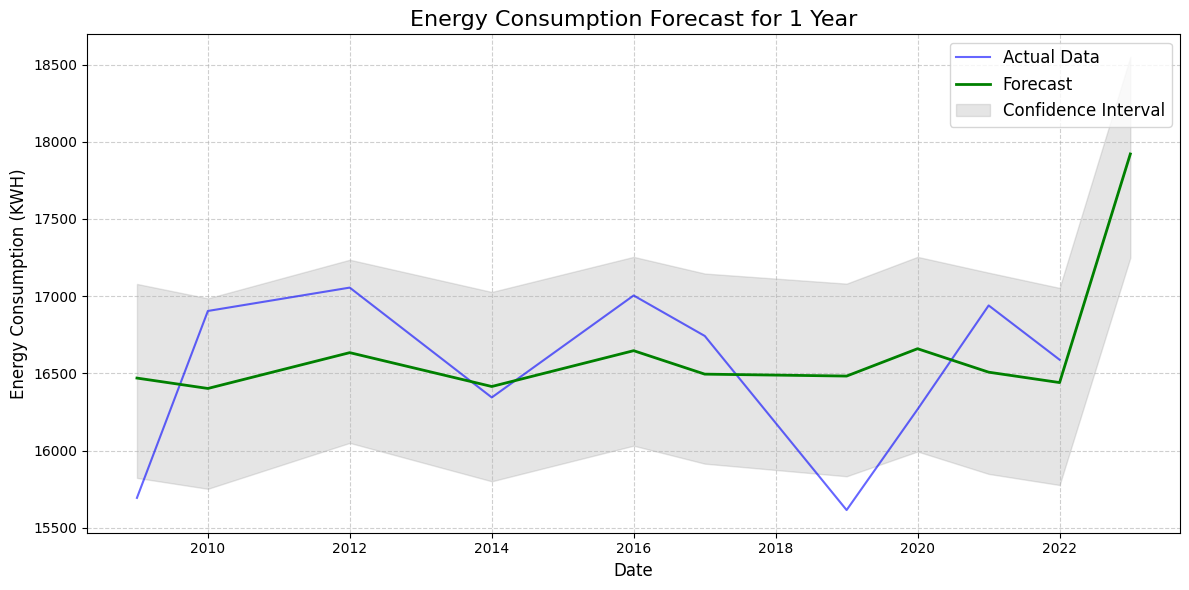

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/7tn63q_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/yp1ud6h6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52164', 'data', 'file=/tmp/tmpkr712cnu/7tn63q_8.json', 'init=/tmp/tmpkr712cnu/yp1ud6h6.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelpycd9zbx/prophet_model-20241211003815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:38:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

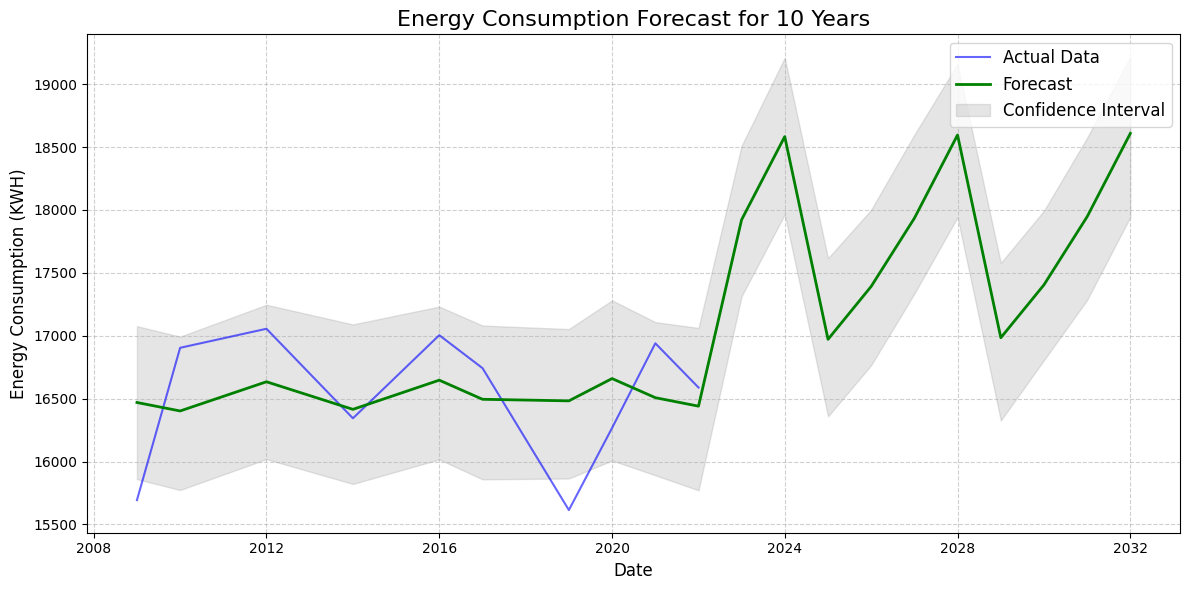

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/0257wfcb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/plam5gjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71553', 'data', 'file=/tmp/tmpkr712cnu/0257wfcb.json', 'init=/tmp/tmpkr712cnu/plam5gjt.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modeln7pi31ew/prophet_model-20241211003816.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:38:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

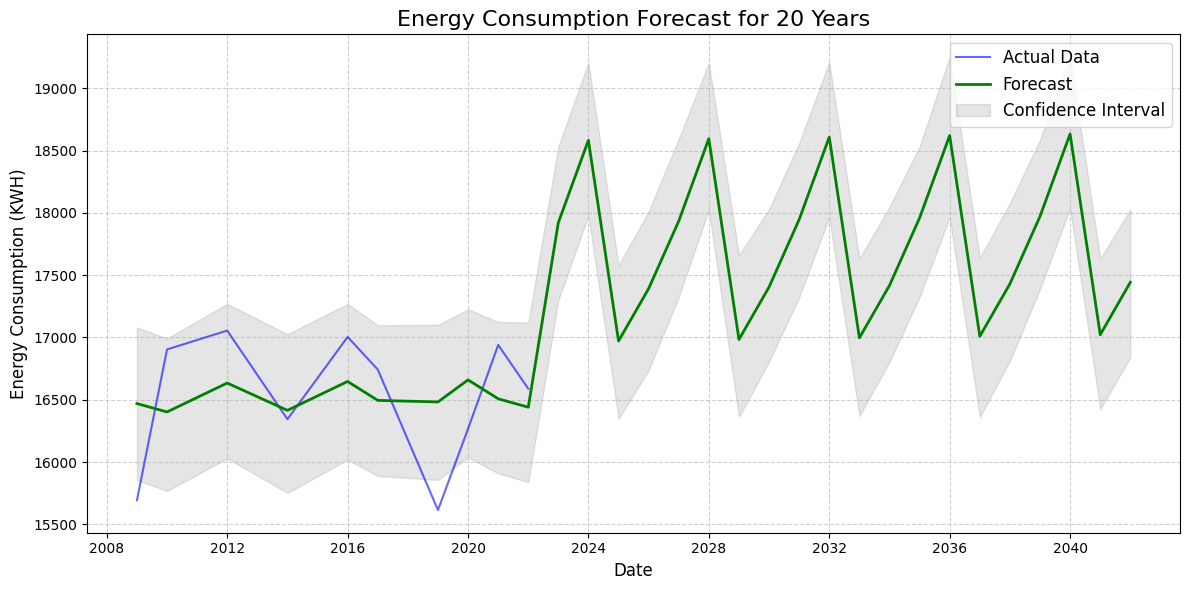


Head of 1 Year Forecast:
          ds          yhat    yhat_lower    yhat_upper
0 2009-01-01  16469.495273  15822.727973  17079.231459
1 2010-01-01  16402.155293  15752.142673  16985.953947
2 2012-01-01  16634.213265  16049.475012  17235.956287
3 2014-01-01  16414.874532  15800.736291  17027.272926
4 2016-01-01  16646.932505  16031.457753  17254.665193

Tail of 1 Year Forecast:
           ds          yhat    yhat_lower    yhat_upper
6  2019-01-01  16482.501071  15833.352635  17081.229253
7  2020-01-01  16659.651748  15993.746351  17254.654052
8  2021-01-01  16507.652996  15848.570826  17152.306673
9  2022-01-01  16440.313018  15776.638741  17053.602578
10 2022-12-31  17921.233813  17249.226625  18549.451365

Head of 10 Years Forecast:
          ds          yhat    yhat_lower    yhat_upper
0 2009-01-01  16469.495273  15859.978479  17076.319367
1 2010-01-01  16402.155293  15773.989756  16992.944755
2 2012-01-01  16634.213265  16019.189800  17246.311148
3 2014-01-01  16414.874532  15821.

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

def train_and_forecast_yearly(df, periods, title):

    # Train Prophet model
    model = Prophet()
    model.fit(df)

    # Create future DataFrame and make predictions
    future = model.make_future_dataframe(periods=periods, freq='Y')
    forecast = model.predict(future)

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['y'], label="Actual Data", color="blue", alpha=0.6)
    plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="green", linewidth=2)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color="gray", alpha=0.2, label="Confidence Interval")
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Energy Consumption (KWH)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return forecast

# Forecast for 1 year
forecast_1_year = train_and_forecast_yearly(data_yearly, periods=1, title="Energy Consumption Forecast for 1 Year")

# Forecast for 10 years
forecast_10_years = train_and_forecast_yearly(data_yearly, periods=10, title="Energy Consumption Forecast for 10 Years")

# Forecast for 20 years
forecast_20_years = train_and_forecast_yearly(data_yearly, periods=20, title="Energy Consumption Forecast for 20 Years")

# Display head and tail for 1 year forecast
print("\nHead of 1 Year Forecast:")
print(forecast_1_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nTail of 1 Year Forecast:")
print(forecast_1_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Display head and tail for 10 years forecast
print("\nHead of 10 Years Forecast:")
print(forecast_10_years[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nTail of 10 Years Forecast:")
print(forecast_10_years[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Display head and tail for 20 years forecast
print("\nHead of 20 Years Forecast:")
print(forecast_20_years[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nTail of 20 Years Forecast:")
print(forecast_20_years[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [ ]:
# Add 'cap' and 'floor' columns for logistic growth
data_daily_filtered['cap'] = data_daily_filtered['y'].max() * 1.2  # Cap is 20% above the max
data_daily_filtered['floor'] = data_daily_filtered['y'].min() * 0.8  # Floor is 20% below the min

data_monthly['cap'] = data_monthly['y'].max() * 1.2
data_monthly['floor'] = data_monthly['y'].min() * 0.8

data_yearly['cap'] = data_yearly['y'].max() * 1.2
data_yearly['floor'] = data_yearly['y'].min() * 0.8

In [ ]:
from prophet import Prophet

def logistic_forecast(df, periods, freq, title):

    # Train the model with logistic growth
    model = Prophet(growth='logistic')
    model.fit(df)

    # Create future DataFrame and ensure 'cap' and 'floor' are consistent
    future = model.make_future_dataframe(periods=periods, freq=freq)
    future['cap'] = df['cap'].iloc[0]
    if 'floor' in df.columns:
        future['floor'] = df['floor'].iloc[0]

    # Generate forecast
    forecast = model.predict(future)

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['y'], label="Actual Data", color="blue", alpha=0.6)
    plt.plot(forecast['ds'], forecast['yhat'], label="Logistic Forecast", color="green", linewidth=2)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color="gray", alpha=0.2, label="Confidence Interval")
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Energy Consumption (KWH)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return forecast

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/w4bfz4hd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/zkk0cxop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76262', 'data', 'file=/tmp/tmpkr712cnu/w4bfz4hd.json', 'init=/tmp/tmpkr712cnu/zkk0cxop.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modeluoxgvqnh/prophet_model-20241211003818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:38:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


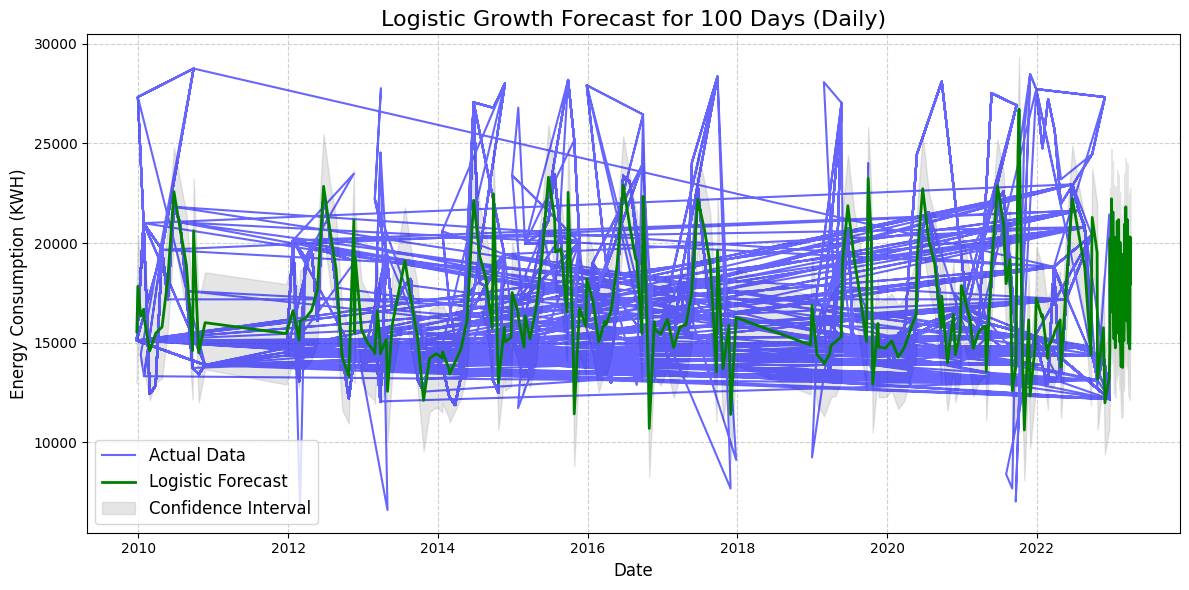

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/xcbtb_jk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/n2xuau8w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46210', 'data', 'file=/tmp/tmpkr712cnu/xcbtb_jk.json', 'init=/tmp/tmpkr712cnu/n2xuau8w.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelvzr_fkvj/prophet_model-20241211003858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:38:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:39:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


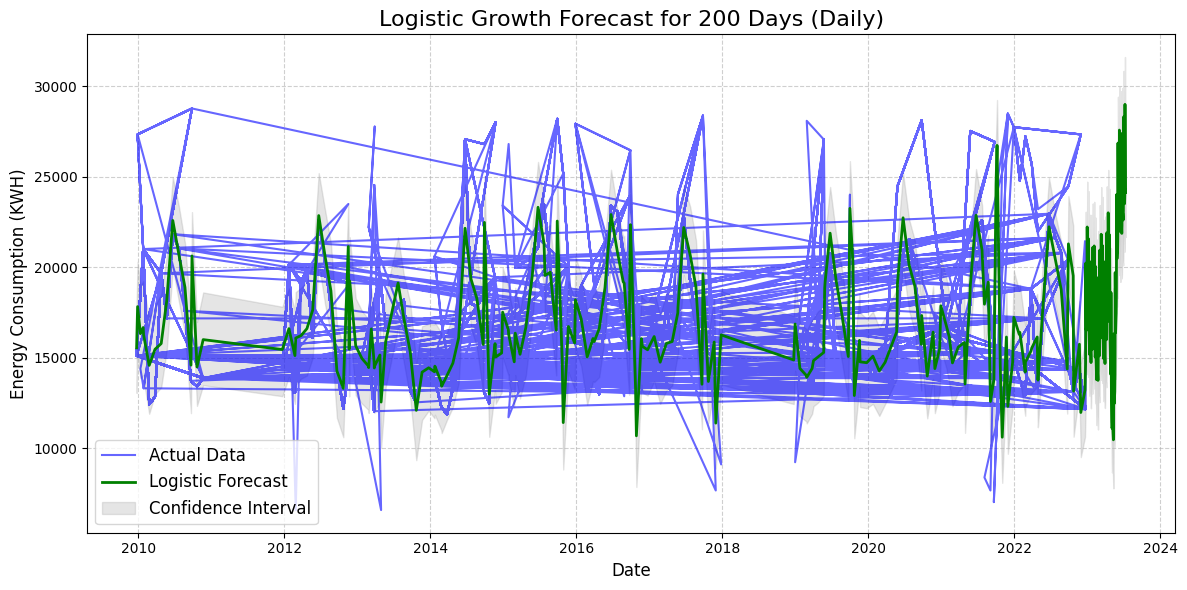

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/2fgvhgx9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/3fdj90d_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=465', 'data', 'file=/tmp/tmpkr712cnu/2fgvhgx9.json', 'init=/tmp/tmpkr712cnu/3fdj90d_.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_model1laz768n/prophet_model-20241211003938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:39:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:40:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


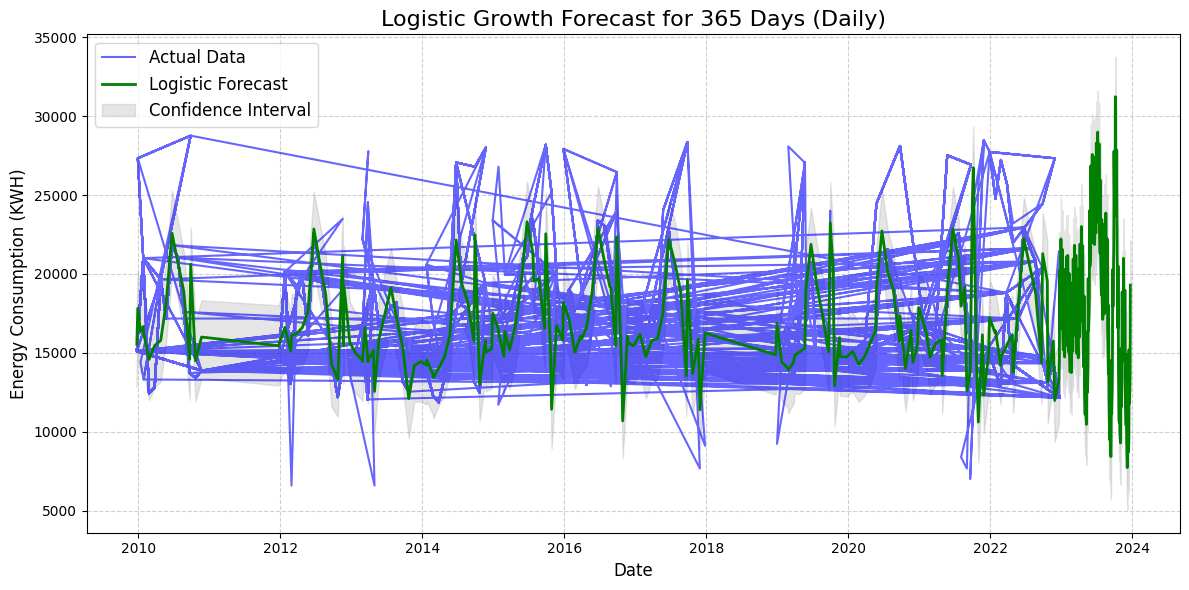

In [ ]:
# Forecast for 100 days
forecast_100_days_logistic = logistic_forecast(data_daily_filtered, periods=100, freq='D', title="Logistic Growth Forecast for 100 Days (Daily)")

# Forecast for 200 days
forecast_200_days_logistic = logistic_forecast(data_daily_filtered, periods=200, freq='D', title="Logistic Growth Forecast for 200 Days (Daily)")

# Forecast for 365 days
forecast_365_days_logistic = logistic_forecast(data_daily_filtered, periods=365, freq='D', title="Logistic Growth Forecast for 365 Days (Daily)")

In [ ]:
print("Logistic Growth Forecast for 100 Days (Head):")
print(forecast_100_days_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nLogistic Growth Forecast for 100 Days (Tail):")
print(forecast_100_days_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("Logistic Growth Forecast for 200 Days (Head):")
print(forecast_200_days_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nLogistic Growth Forecast for 200 Days (Tail):")
print(forecast_200_days_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("Logistic Growth Forecast for 365 Days (Head):")
print(forecast_365_days_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nLogistic Growth Forecast for 365 Days (Tail):")
print(forecast_365_days_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Logistic Growth Forecast for 100 Days (Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-24  15552.322062  12968.121960  18003.797210
1 2009-12-29  17826.683442  15368.129854  20383.626402
2 2010-01-12  16334.973279  13823.717690  18721.548158
3 2010-01-26  16673.551019  14226.734143  19253.552528
4 2010-01-28  16267.634359  13674.957219  18791.740378

Logistic Growth Forecast for 100 Days (Tail):
            ds          yhat    yhat_lower    yhat_upper
296 2023-03-29  14946.857864  12275.157779  17433.898206
297 2023-03-30  14685.914585  12135.333368  17223.989667
298 2023-03-31  15173.914784  12727.073545  17840.396015
299 2023-04-01  20313.594309  17745.272300  22747.477005
300 2023-04-02  17951.381619  15472.490031  20606.321168
Logistic Growth Forecast for 200 Days (Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-24  15552.322062  13063.965588  18011.370050
1 2009-12-29  17826.683442  15308.849020  20301.834892
2 2010-01-12  16334.9732

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/t7zbolh7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/tce3sk_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83931', 'data', 'file=/tmp/tmpkr712cnu/t7zbolh7.json', 'init=/tmp/tmpkr712cnu/tce3sk_h.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_model795l5eh9/prophet_model-20241211004016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:40:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:40:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

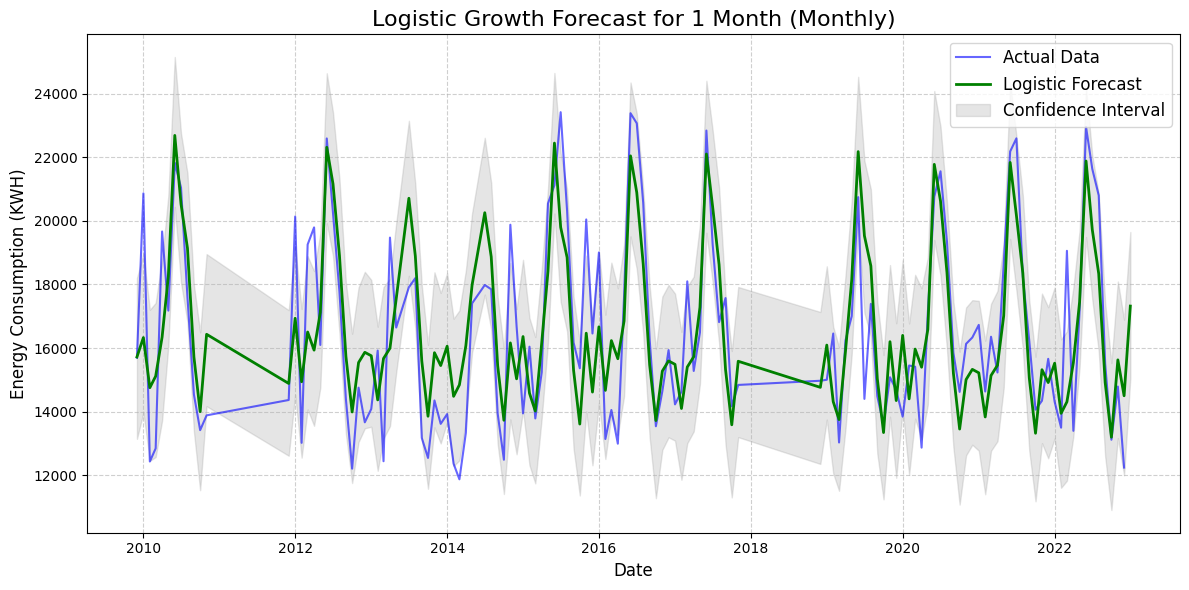

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/xcj8co66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/37h3ufqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6437', 'data', 'file=/tmp/tmpkr712cnu/xcj8co66.json', 'init=/tmp/tmpkr712cnu/37h3ufqf.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_model25vslh6q/prophet_model-20241211004016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:40:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:40:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/p

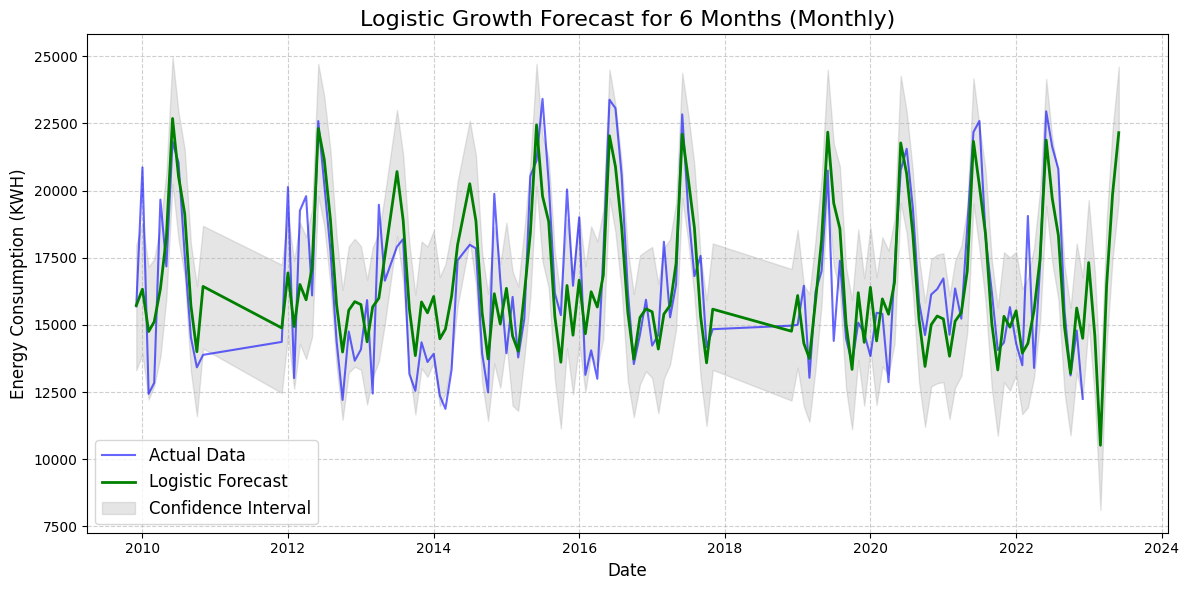

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/skue6dj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/66zqhw3m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91945', 'data', 'file=/tmp/tmpkr712cnu/skue6dj9.json', 'init=/tmp/tmpkr712cnu/66zqhw3m.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelor1_z2s4/prophet_model-20241211004017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:40:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:40:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

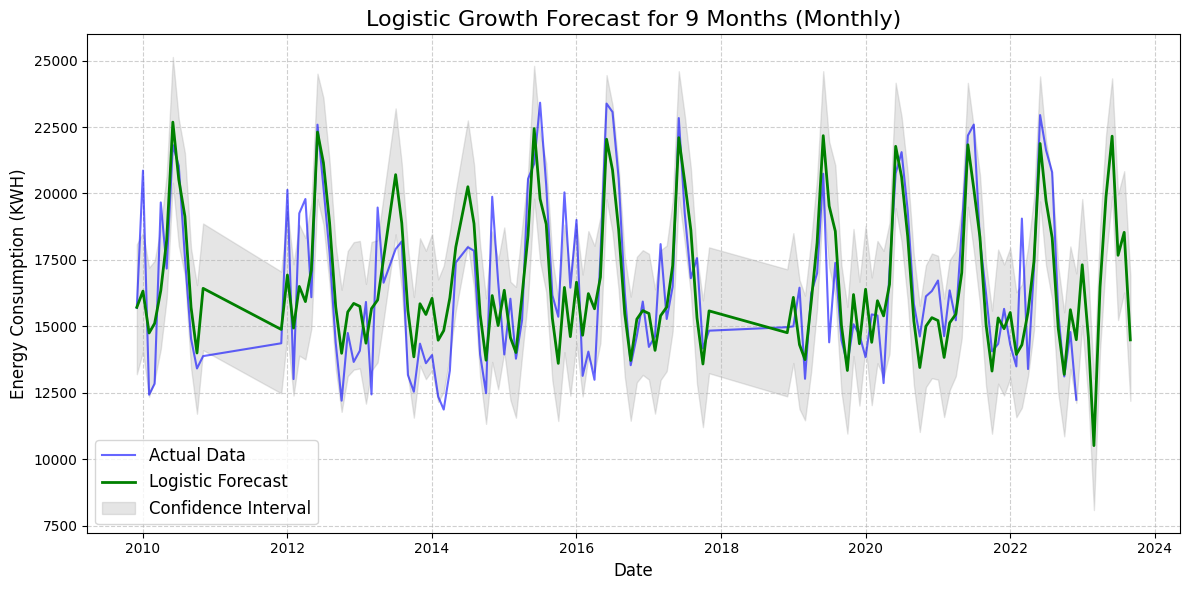

In [ ]:
# Forecast for 1 month
forecast_1_month_logistic = logistic_forecast(data_monthly, periods=1, freq='M', title="Logistic Growth Forecast for 1 Month (Monthly)")

# Forecast for 6 months
forecast_6_months_logistic = logistic_forecast(data_monthly, periods=6, freq='M', title="Logistic Growth Forecast for 6 Months (Monthly)")

# Forecast for 9 months
forecast_9_months_logistic = logistic_forecast(data_monthly, periods=9, freq='M', title="Logistic Growth Forecast for 9 Months (Monthly)")

In [ ]:
print("Logistic Growth Forecast for 1 Month (Head):")
print(forecast_1_month_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nLogistic Growth Forecast for 1 Month (Tail):")
print(forecast_1_month_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("Logistic Growth Forecast for 6 Months (Head):")
print(forecast_6_months_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nLogistic Growth Forecast for 6 Months (Tail):")
print(forecast_6_months_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("Logistic Growth Forecast for 9 Months (Head):")
print(forecast_9_months_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nLogistic Growth Forecast for 9 Months (Tail):")
print(forecast_9_months_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Logistic Growth Forecast for 1 Month (Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-01  15720.388937  13144.463445  18196.885806
1 2010-01-01  16329.359211  13969.483804  18968.226233
2 2010-02-01  14753.394235  12453.964712  17202.749440
3 2010-03-01  15114.331520  12571.836537  17417.625093
4 2010-04-01  16345.450923  13720.207958  18766.299559

Logistic Growth Forecast for 1 Month (Tail):
            ds          yhat    yhat_lower    yhat_upper
127 2022-09-01  14916.271658  12588.213140  17410.928625
128 2022-10-01  13196.111709  10906.084832  15527.589120
129 2022-11-01  15627.991363  13169.905056  18091.521306
130 2022-12-01  14499.267641  11999.907932  16892.781602
131 2022-12-31  17319.054763  15046.137655  19647.286683
Logistic Growth Forecast for 6 Months (Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-01  15720.388937  13312.673045  17990.244319
1 2010-01-01  16329.359211  13910.459616  18774.217427
2 2010-02-01  14753.394235

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/5vshgt49.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/31n99ll_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84358', 'data', 'file=/tmp/tmpkr712cnu/5vshgt49.json', 'init=/tmp/tmpkr712cnu/31n99ll_.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelf2clwgjd/prophet_model-20241211004018.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:40:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:40:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

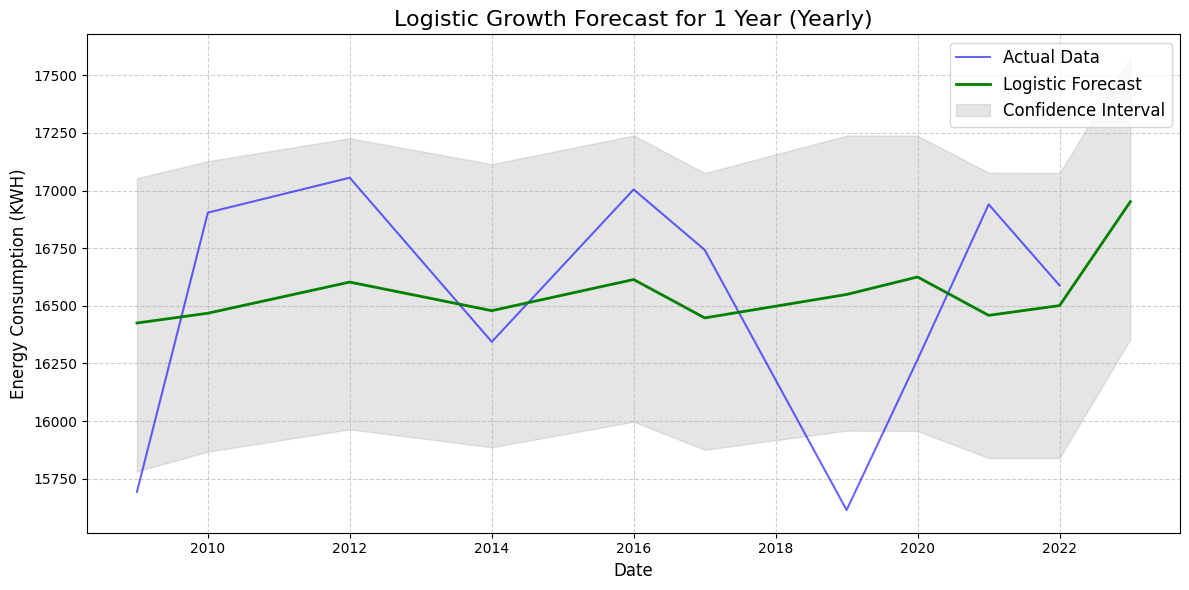

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/a3mkzwvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/49bq3b29.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30229', 'data', 'file=/tmp/tmpkr712cnu/a3mkzwvx.json', 'init=/tmp/tmpkr712cnu/49bq3b29.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modeluzxany_b/prophet_model-20241211004020.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:40:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:40:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

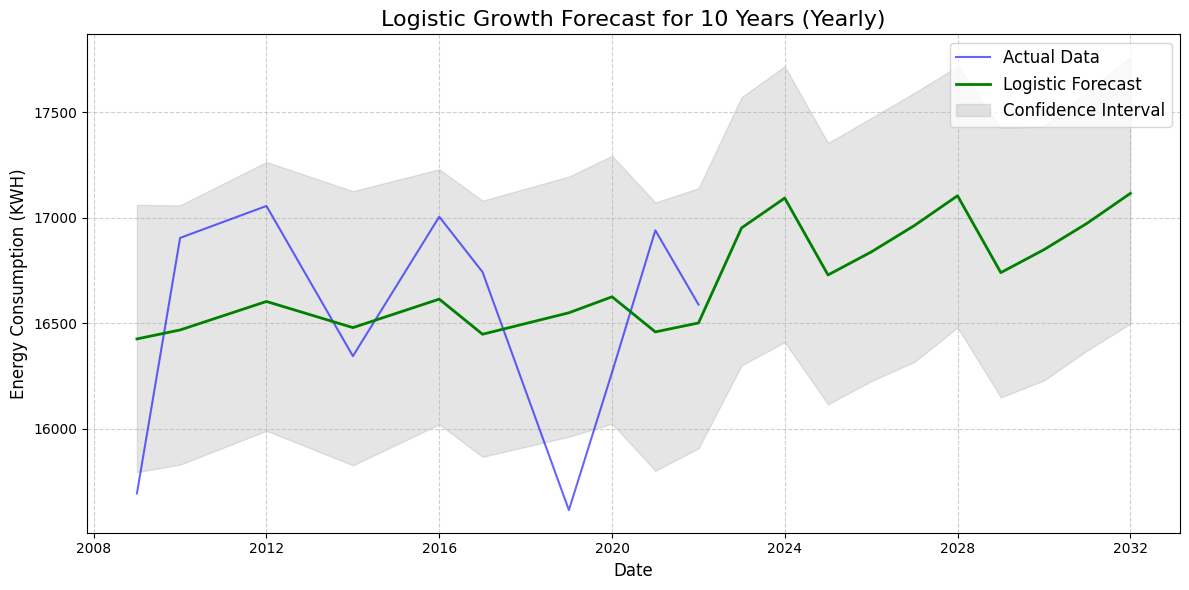

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/y37x1uc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/_e2o5mqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33734', 'data', 'file=/tmp/tmpkr712cnu/y37x1uc_.json', 'init=/tmp/tmpkr712cnu/_e2o5mqf.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelo9k95tsv/prophet_model-20241211004021.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:40:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:40:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

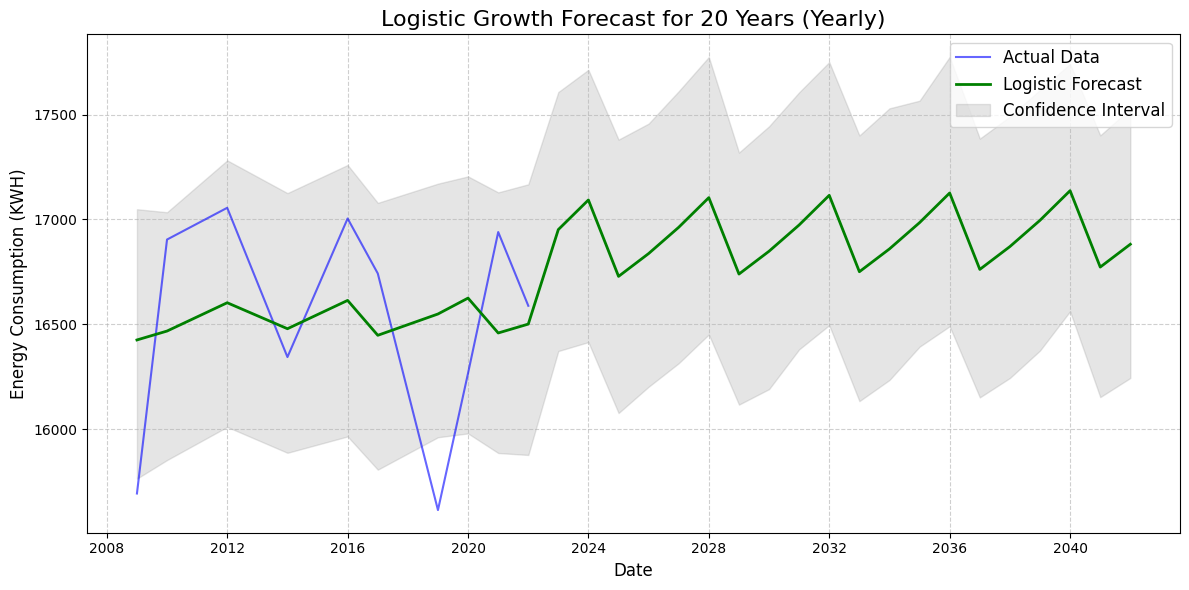

In [ ]:
# Forecast for 1 year
forecast_1_year_logistic = logistic_forecast(data_yearly, periods=1, freq='Y', title="Logistic Growth Forecast for 1 Year (Yearly)")

# Forecast for 10 years
forecast_10_years_logistic = logistic_forecast(data_yearly, periods=10, freq='Y', title="Logistic Growth Forecast for 10 Years (Yearly)")

# Forecast for 20 years
forecast_20_years_logistic = logistic_forecast(data_yearly, periods=20, freq='Y', title="Logistic Growth Forecast for 20 Years (Yearly)")

In [ ]:
print("Logistic Growth Forecast for 1 Year (Head):")
print(forecast_1_year_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nLogistic Growth Forecast for 1 Year (Tail):")
print(forecast_1_year_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("Logistic Growth Forecast for 10 Years (Head):")
print(forecast_10_years_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nLogistic Growth Forecast for 10 Years (Tail):")
print(forecast_10_years_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

print("Logistic Growth Forecast for 20 Years (Head):")
print(forecast_20_years_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nLogistic Growth Forecast for 20 Years (Tail):")
print(forecast_20_years_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Logistic Growth Forecast for 1 Year (Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-01-01  16425.460338  15782.641276  17053.118124
1 2010-01-01  16467.898095  15867.438718  17127.288005
2 2012-01-01  16602.917330  15964.332835  17226.635477
3 2014-01-01  16478.978934  15886.833141  17114.456303
4 2016-01-01  16613.998194  15997.249243  17238.497501

Logistic Growth Forecast for 1 Year (Tail):
           ds          yhat    yhat_lower    yhat_upper
6  2019-01-01  16549.233738  15958.756290  17238.185754
7  2020-01-01  16625.078984  15957.279685  17237.394877
8  2021-01-01  16458.702756  15840.010652  17077.363504
9  2022-01-01  16501.140471  15840.169141  17075.815988
10 2022-12-31  16951.552768  16354.427514  17578.940218
Logistic Growth Forecast for 10 Years (Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-01-01  16425.460338  15794.043584  17060.781260
1 2010-01-01  16467.898095  15829.794944  17058.443069
2 2012-01-01  16602.917330  15990.

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

def flat_forecast(df, periods, freq, title):

    # Train Prophet model with suppressed changepoints
    model = Prophet(n_changepoints=0, changepoint_prior_scale=0.001)
    model.fit(df)

    # Create future DataFrame and make predictions
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['y'], label="Actual Data", color="blue", alpha=0.6)
    plt.plot(forecast['ds'], forecast['yhat'], label="Flat Growth Forecast", color="green", linewidth=2)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color="gray", alpha=0.2, label="Confidence Interval")
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Energy Consumption (KWH)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return forecast

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/j6kbnx9c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/7hcsha8i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58505', 'data', 'file=/tmp/tmpkr712cnu/j6kbnx9c.json', 'init=/tmp/tmpkr712cnu/7hcsha8i.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelrycc2jgu/prophet_model-20241211004023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:40:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:40:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
00:40:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during 

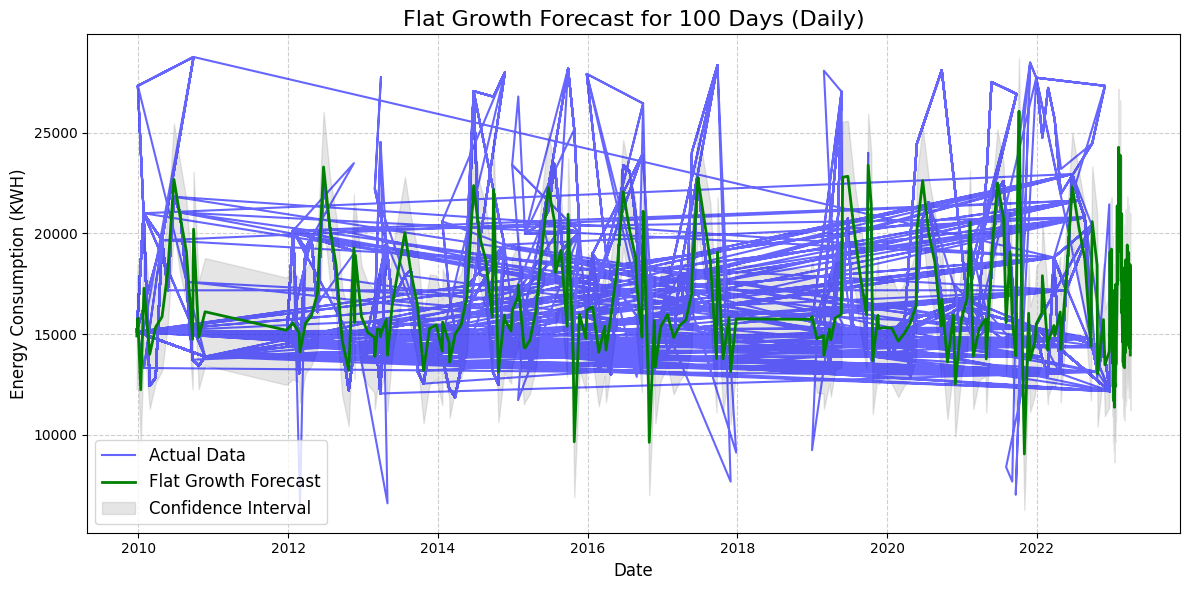

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/za6b4q_4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/olrkitjk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2126', 'data', 'file=/tmp/tmpkr712cnu/za6b4q_4.json', 'init=/tmp/tmpkr712cnu/olrkitjk.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_model55kz2wvk/prophet_model-20241211004048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:40:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:40:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
00:40:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during p

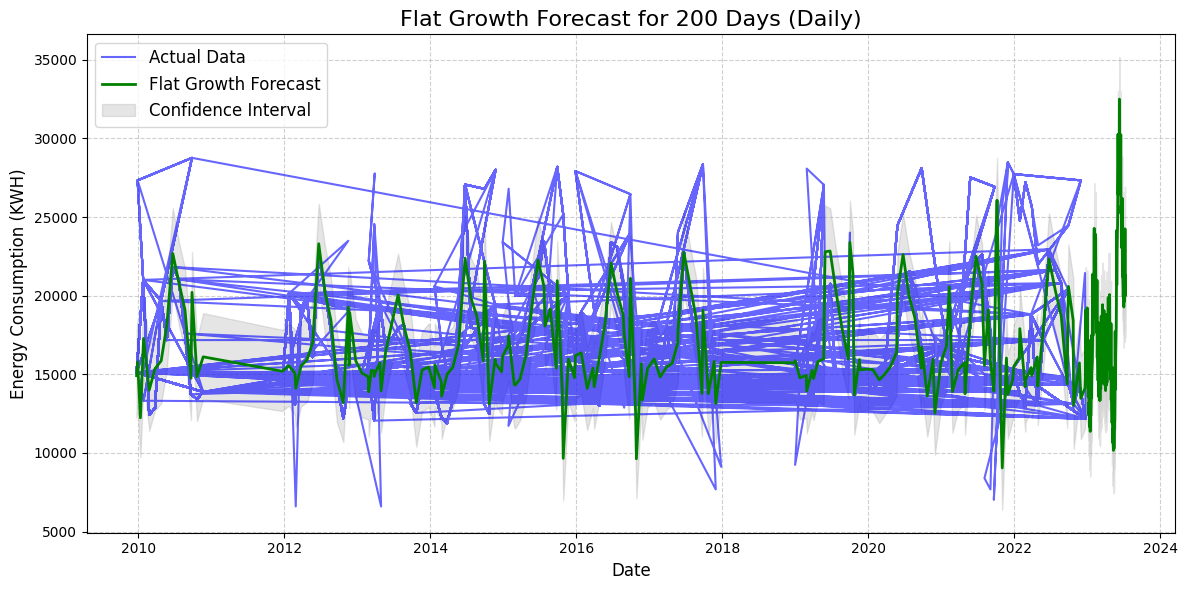

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/26od2152.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/r7x4deh9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12532', 'data', 'file=/tmp/tmpkr712cnu/26od2152.json', 'init=/tmp/tmpkr712cnu/r7x4deh9.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_model0ir3f5te/prophet_model-20241211004111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
00:41:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during 

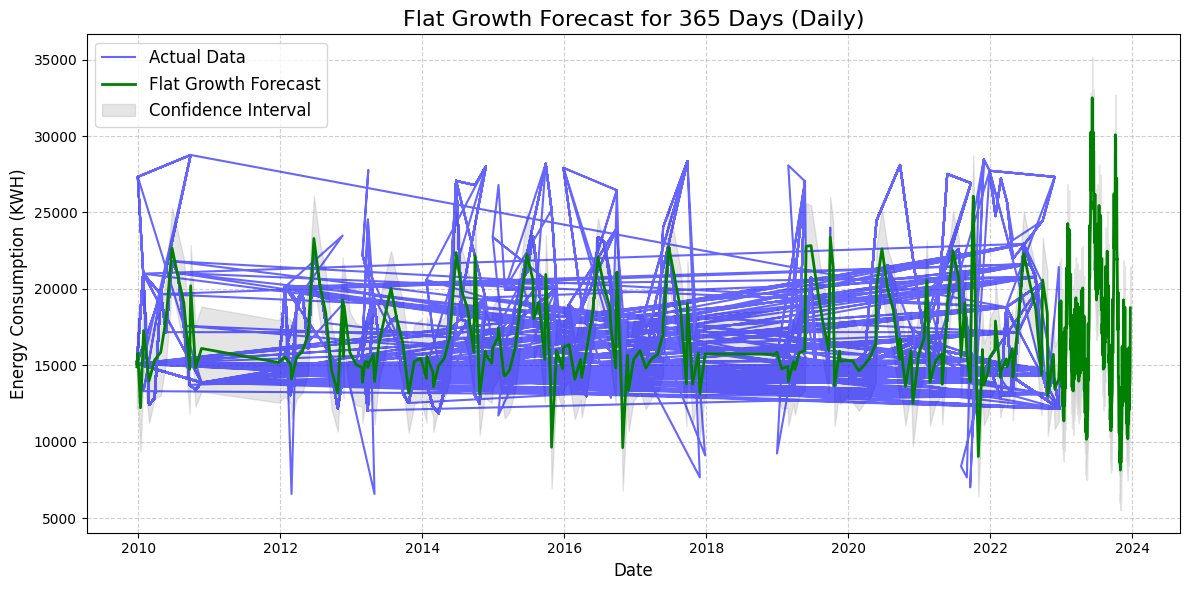

In [ ]:
forecast_100_days_flat = flat_forecast(data_daily_filtered, periods=100, freq='D', title="Flat Growth Forecast for 100 Days (Daily)")
forecast_200_days_flat = flat_forecast(data_daily_filtered, periods=200, freq='D', title="Flat Growth Forecast for 200 Days (Daily)")
forecast_365_days_flat = flat_forecast(data_daily_filtered, periods=365, freq='D', title="Flat Growth Forecast for 365 Days (Daily)")

In [ ]:
# Flat Growth Forecast for 100 Days
print("Flat Growth Forecast for 100 Days (Head):")
print(forecast_100_days_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nFlat Growth Forecast for 100 Days (Tail):")
print(forecast_100_days_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Flat Growth Forecast for 200 Days
print("\nFlat Growth Forecast for 200 Days (Head):")
print(forecast_200_days_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nFlat Growth Forecast for 200 Days (Tail):")
print(forecast_200_days_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Flat Growth Forecast for 365 Days
print("\nFlat Growth Forecast for 365 Days (Head):")
print(forecast_365_days_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nFlat Growth Forecast for 365 Days (Tail):")
print(forecast_365_days_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Flat Growth Forecast for 100 Days (Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-24  14911.655915  12265.171373  17627.975461
1 2009-12-29  15794.947961  13231.610948  18472.925325
2 2010-01-12  12235.863037   9633.633960  15125.958781
3 2010-01-26  16681.952721  14067.555246  19453.649946
4 2010-01-28  17279.249525  14619.331620  19813.730682

Flat Growth Forecast for 100 Days (Tail):
            ds          yhat    yhat_lower    yhat_upper
296 2023-03-29  14689.559384  11959.730887  17431.113809
297 2023-03-30  14288.241848  11848.430159  17171.190253
298 2023-03-31  14887.140405  12344.569394  17547.087870
299 2023-04-01  18451.838096  15788.005348  21037.219689
300 2023-04-02  13965.529317  11210.116619  16738.981200

Flat Growth Forecast for 200 Days (Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-24  14911.655915  12251.973131  17814.705412
1 2009-12-29  15794.947961  13054.088162  18524.132597
2 2010-01-12  12235.863037   9732.2

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/4928atkq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/v6ap7mjw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2366', 'data', 'file=/tmp/tmpkr712cnu/4928atkq.json', 'init=/tmp/tmpkr712cnu/v6ap7mjw.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_model45ovct8w/prophet_model-20241211004134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
00:41:34 - cmdstanpy - ERROR - Chain [1] 

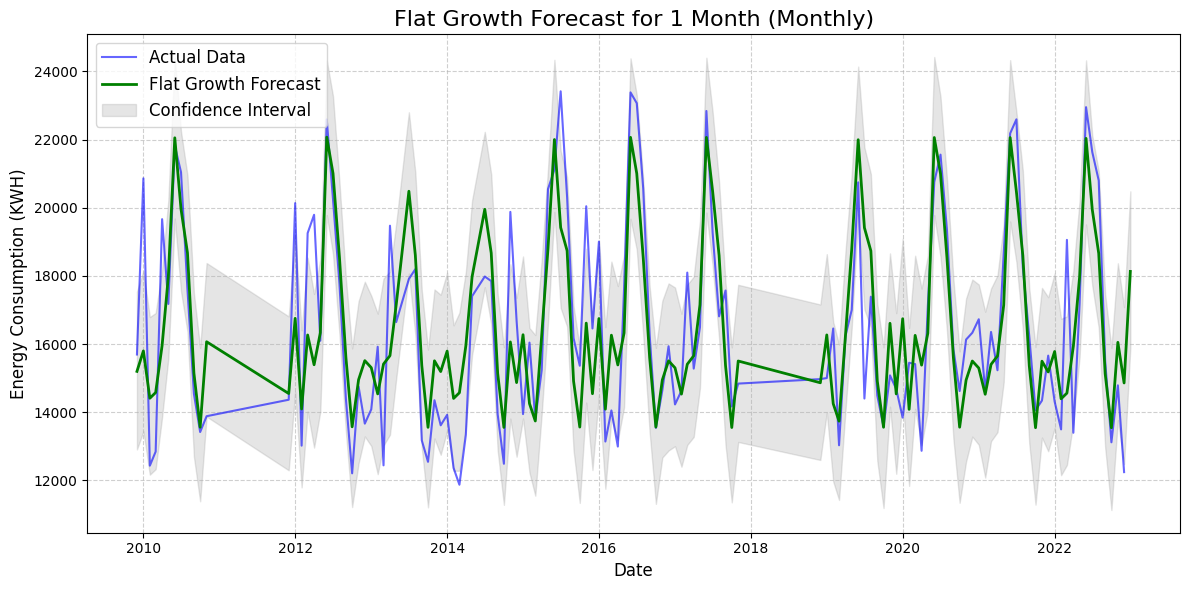

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/o340mofn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/tr0p2mye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54056', 'data', 'file=/tmp/tmpkr712cnu/o340mofn.json', 'init=/tmp/tmpkr712cnu/tr0p2mye.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modeldfv0e25g/prophet_model-20241211004135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
00:41:35 - cmdstanpy - ERROR - Chain [1]

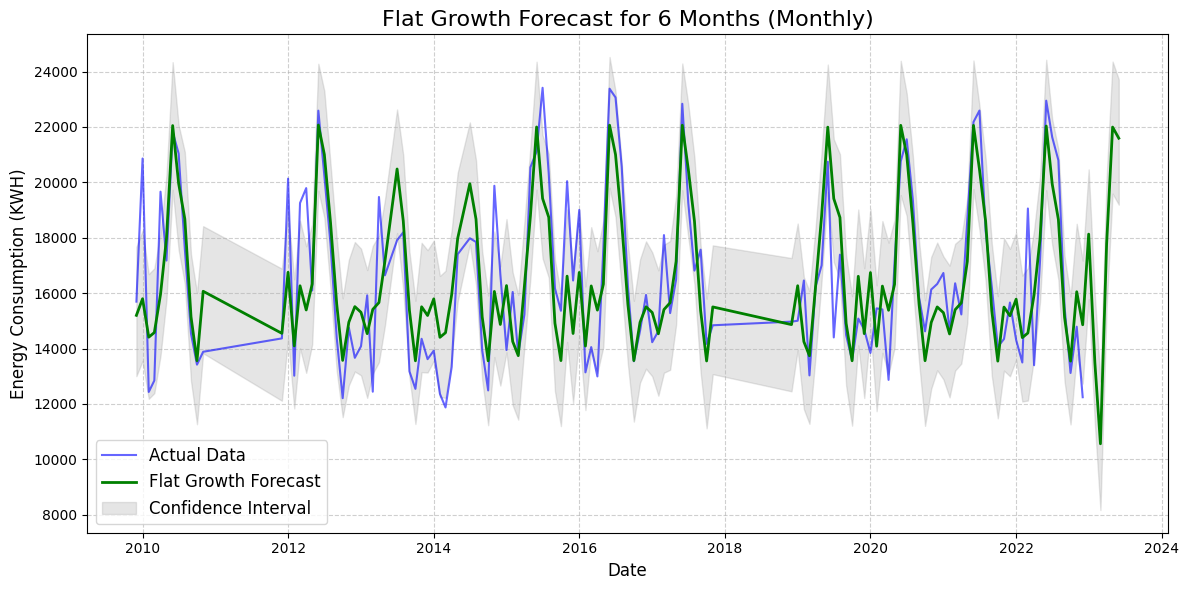

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/ax3gfktb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/cbt_qe88.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39618', 'data', 'file=/tmp/tmpkr712cnu/ax3gfktb.json', 'init=/tmp/tmpkr712cnu/cbt_qe88.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelfunkxll5/prophet_model-20241211004136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
00:41:36 - cmdstanpy - ERROR - Chain [1]

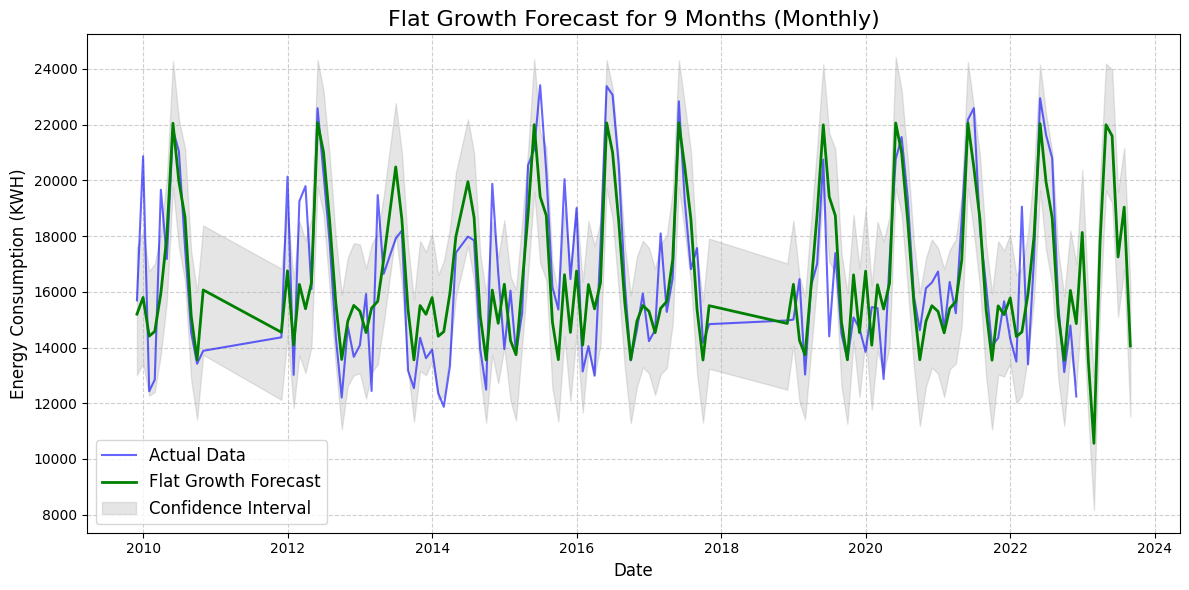

In [ ]:
forecast_1_month_flat = flat_forecast(data_monthly, periods=1, freq='M', title="Flat Growth Forecast for 1 Month (Monthly)")
forecast_6_months_flat = flat_forecast(data_monthly, periods=6, freq='M', title="Flat Growth Forecast for 6 Months (Monthly)")
forecast_9_months_flat = flat_forecast(data_monthly, periods=9, freq='M', title="Flat Growth Forecast for 9 Months (Monthly)")

In [ ]:
# Flat Growth Forecast for 1 Month
print("Flat Growth Forecast for 1 Month (Head):")
print(forecast_1_month_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nFlat Growth Forecast for 1 Month (Tail):")
print(forecast_1_month_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Flat Growth Forecast for 6 Months
print("\nFlat Growth Forecast for 6 Months (Head):")
print(forecast_6_months_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nFlat Growth Forecast for 6 Months (Tail):")
print(forecast_6_months_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Flat Growth Forecast for 9 Months
print("\nFlat Growth Forecast for 9 Months (Head):")
print(forecast_9_months_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nFlat Growth Forecast for 9 Months (Tail):")
print(forecast_9_months_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Flat Growth Forecast for 1 Month (Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-01  15198.404149  12908.280536  17538.002160
1 2010-01-01  15798.504762  13439.154567  18140.178057
2 2010-02-01  14410.418129  12167.342988  16791.836240
3 2010-03-01  14577.731347  12330.434760  16911.364116
4 2010-04-01  15958.309183  13858.264412  18173.525797

Flat Growth Forecast for 1 Month (Tail):
            ds          yhat    yhat_lower    yhat_upper
127 2022-09-01  15130.963285  12966.762745  17458.111450
128 2022-10-01  13543.368217  11129.722782  15888.782487
129 2022-11-01  16050.829280  13768.203308  18370.343250
130 2022-12-01  14858.365369  12480.890939  17083.131642
131 2022-12-31  18130.772455  15880.325330  20480.417253

Flat Growth Forecast for 6 Months (Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-01  15198.404149  13003.701793  17667.094941
1 2010-01-01  15798.504762  13554.076470  18255.927780
2 2010-02-01  14410.418129  12184.607

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/g2_kvums.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/4wrnevw5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24136', 'data', 'file=/tmp/tmpkr712cnu/g2_kvums.json', 'init=/tmp/tmpkr712cnu/4wrnevw5.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_model2q977cbj/prophet_model-20241211004137.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:41:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages

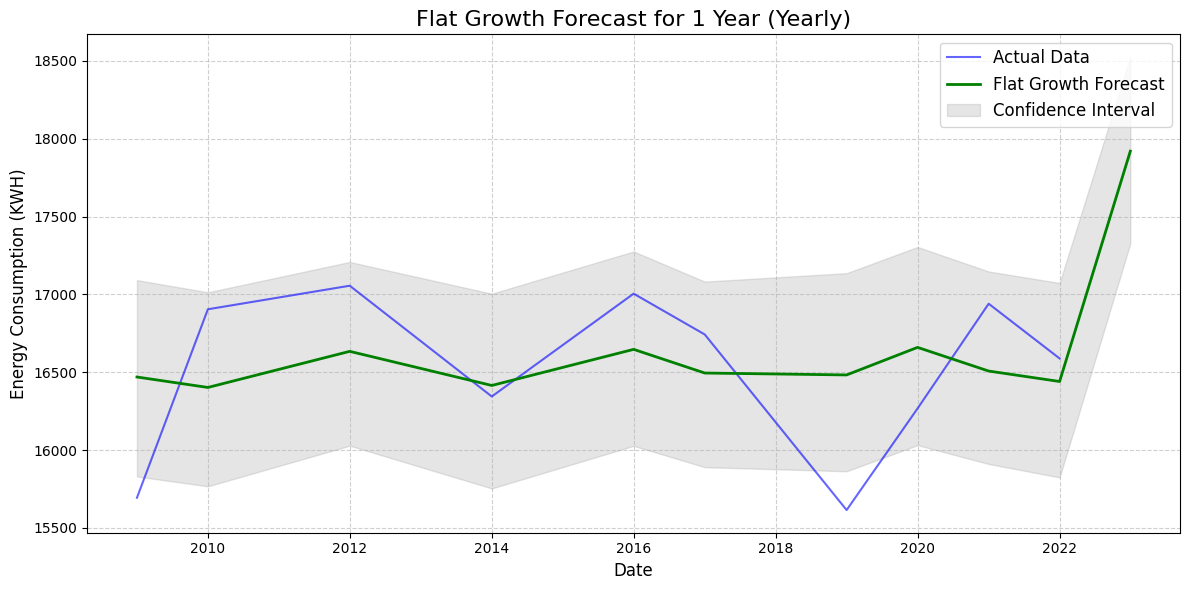

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/dwhetrg3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/lky6lfgg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67771', 'data', 'file=/tmp/tmpkr712cnu/dwhetrg3.json', 'init=/tmp/tmpkr712cnu/lky6lfgg.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_model52ebnzix/prophet_model-20241211004138.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages

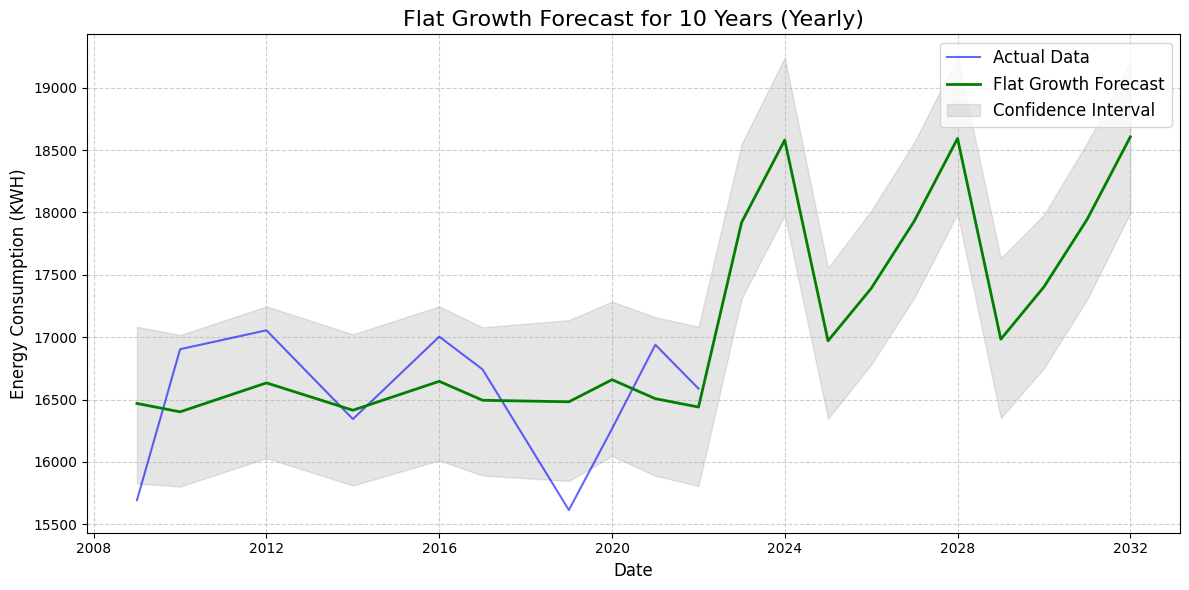

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/slbsmpwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/9qc2v2b4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17106', 'data', 'file=/tmp/tmpkr712cnu/slbsmpwv.json', 'init=/tmp/tmpkr712cnu/9qc2v2b4.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modeli93fhmlm/prophet_model-20241211004138.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages

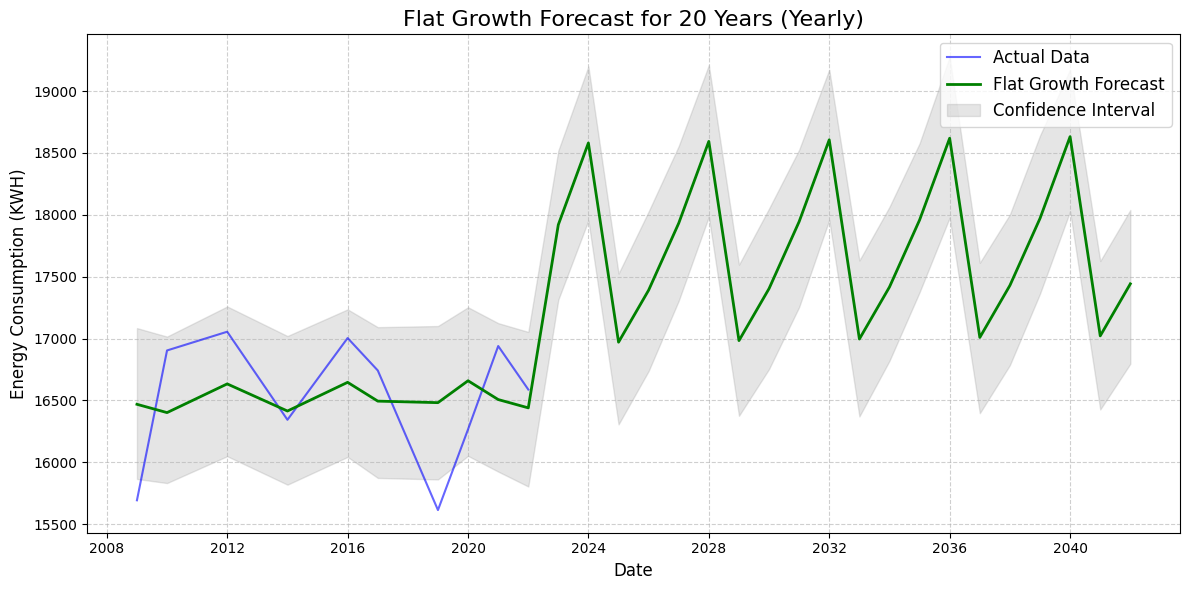

In [ ]:
forecast_1_year_flat = flat_forecast(data_yearly, periods=1, freq='Y', title="Flat Growth Forecast for 1 Year (Yearly)")
forecast_10_years_flat = flat_forecast(data_yearly, periods=10, freq='Y', title="Flat Growth Forecast for 10 Years (Yearly)")
forecast_20_years_flat = flat_forecast(data_yearly, periods=20, freq='Y', title="Flat Growth Forecast for 20 Years (Yearly)")

In [ ]:
# Flat Growth Forecast for 1 Year
print("Flat Growth Forecast for 1 Year (Head):")
print(forecast_1_year_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nFlat Growth Forecast for 1 Year (Tail):")
print(forecast_1_year_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Flat Growth Forecast for 10 Years
print("\nFlat Growth Forecast for 10 Years (Head):")
print(forecast_10_years_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nFlat Growth Forecast for 10 Years (Tail):")
print(forecast_10_years_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Flat Growth Forecast for 20 Years
print("\nFlat Growth Forecast for 20 Years (Head):")
print(forecast_20_years_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nFlat Growth Forecast for 20 Years (Tail):")
print(forecast_20_years_flat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Flat Growth Forecast for 1 Year (Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-01-01  16469.145497  15830.315407  17091.603235
1 2010-01-01  16401.978696  15767.082033  17013.195472
2 2012-01-01  16633.929589  16028.037270  17208.136994
3 2014-01-01  16414.742021  15753.291883  17004.305417
4 2016-01-01  16646.692914  16026.877158  17275.564415

Flat Growth Forecast for 1 Year (Tail):
           ds          yhat    yhat_lower    yhat_upper
6  2019-01-01  16482.434682  15863.728088  17136.135520
7  2020-01-01  16659.456239  16031.474105  17304.575928
8  2021-01-01  16507.435472  15910.491552  17147.088053
9  2022-01-01  16440.268671  15824.074000  17073.253383
10 2022-12-31  17919.747796  17326.673566  18524.770515

Flat Growth Forecast for 10 Years (Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-01-01  16469.145497  15827.911507  17083.595106
1 2010-01-01  16401.978696  15802.757415  17017.550555
2 2012-01-01  16633.929589  16030.706679  172

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

def add_seasonality_and_forecast(df, periods, freq, title, seasonality_period, fourier_order):

    # Initialize Prophet model
    model = Prophet()

    # Add custom seasonality
    model.add_seasonality(name='custom_seasonality', period=seasonality_period, fourier_order=fourier_order)

    # Fit the model
    model.fit(df)

    # Create future DataFrame and make predictions
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['y'], label="Actual Data", color="blue", alpha=0.6)
    plt.plot(forecast['ds'], forecast['yhat'], label="Forecast with Custom Seasonality", color="green", linewidth=2)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color="gray", alpha=0.2, label="Confidence Interval")
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Energy Consumption (KWH)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return forecast

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/8d3489yl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/do6no6wt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8387', 'data', 'file=/tmp/tmpkr712cnu/8d3489yl.json', 'init=/tmp/tmpkr712cnu/do6no6wt.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelt2_3bwwt/prophet_model-20241211004141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:42:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


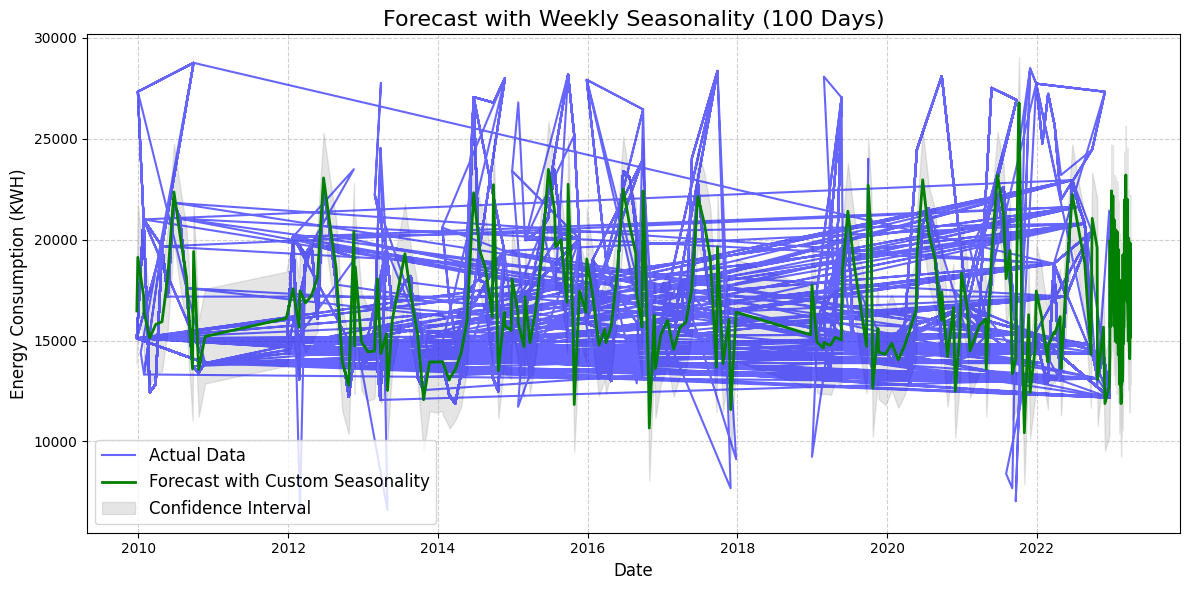

Forecast with Weekly Seasonality (100 Days - Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-24  16467.898622  13852.235900  18898.818785
1 2009-12-29  19123.690713  16582.437138  21718.292890
2 2010-01-12  18154.705029  15838.175044  20398.246006
3 2010-01-26  17230.283596  14898.219273  19789.131326
4 2010-01-28  16417.428373  13960.350283  18935.025424

Forecast with Weekly Seasonality (100 Days - Tail):
            ds          yhat    yhat_lower    yhat_upper
296 2023-03-29  14494.140826  12010.082828  16879.953620
297 2023-03-30  14095.257334  11444.711595  16555.513972
298 2023-03-31  14582.982345  12116.800502  16952.700003
299 2023-04-01  19840.771988  17411.954702  22239.551220
300 2023-04-02  15174.163602  12801.919469  17636.065865


In [ ]:
# Forecast for 100 days with weekly seasonality (period=7, fourier_order=3)
forecast_100_days_seasonality = add_seasonality_and_forecast(
    df=data_daily_filtered,
    periods=100,
    freq='D',
    title="Forecast with Weekly Seasonality (100 Days)",
    seasonality_period=7,  # Weekly seasonality
    fourier_order=3
)

# Display the head and tail
print("Forecast with Weekly Seasonality (100 Days - Head):")
print(forecast_100_days_seasonality[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nForecast with Weekly Seasonality (100 Days - Tail):")
print(forecast_100_days_seasonality[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/i6fie_mz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/jehosetd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40789', 'data', 'file=/tmp/tmpkr712cnu/i6fie_mz.json', 'init=/tmp/tmpkr712cnu/jehosetd.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_model78_1kffs/prophet_model-20241211004212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:42:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:42:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

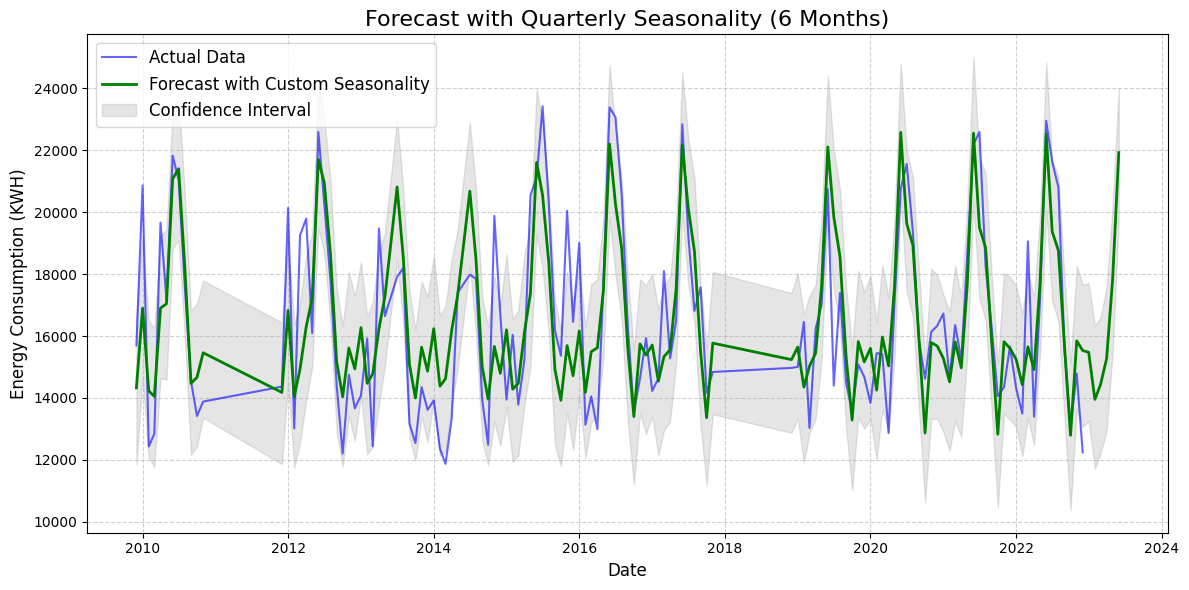

Forecast with Quarterly Seasonality (6 Months - Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-01  14327.003205  11847.858827  16741.440011
1 2010-01-01  16898.019827  14653.204023  19170.563992
2 2010-02-01  14227.889605  12072.180448  16497.122085
3 2010-03-01  14051.360716  11789.215328  16260.713616
4 2010-04-01  16901.101585  14633.592952  19236.083546

Forecast with Quarterly Seasonality (6 Months - Tail):
            ds          yhat    yhat_lower    yhat_upper
132 2023-01-31  13955.998335  11721.445544  16331.553396
133 2023-02-28  14421.749733  12196.145412  16598.506662
134 2023-03-31  15272.082466  12935.083646  17564.582599
135 2023-04-30  17814.944845  15449.863440  20173.688208
136 2023-05-31  21922.775235  19742.087198  23987.374417


In [ ]:
# Forecast for 6 months with quarterly seasonality (period=91.25, fourier_order=5)
forecast_6_months_seasonality = add_seasonality_and_forecast(
    df=data_monthly,
    periods=6,
    freq='M',
    title="Forecast with Quarterly Seasonality (6 Months)",
    seasonality_period=91.25,  # Quarterly seasonality
    fourier_order=5
)

# Display the head and tail
print("Forecast with Quarterly Seasonality (6 Months - Head):")
print(forecast_6_months_seasonality[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nForecast with Quarterly Seasonality (6 Months - Tail):")
print(forecast_6_months_seasonality[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/k051zylh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/oz_8nzot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95404', 'data', 'file=/tmp/tmpkr712cnu/k051zylh.json', 'init=/tmp/tmpkr712cnu/oz_8nzot.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modeli329f4sw/prophet_model-20241211004213.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:42:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:42:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

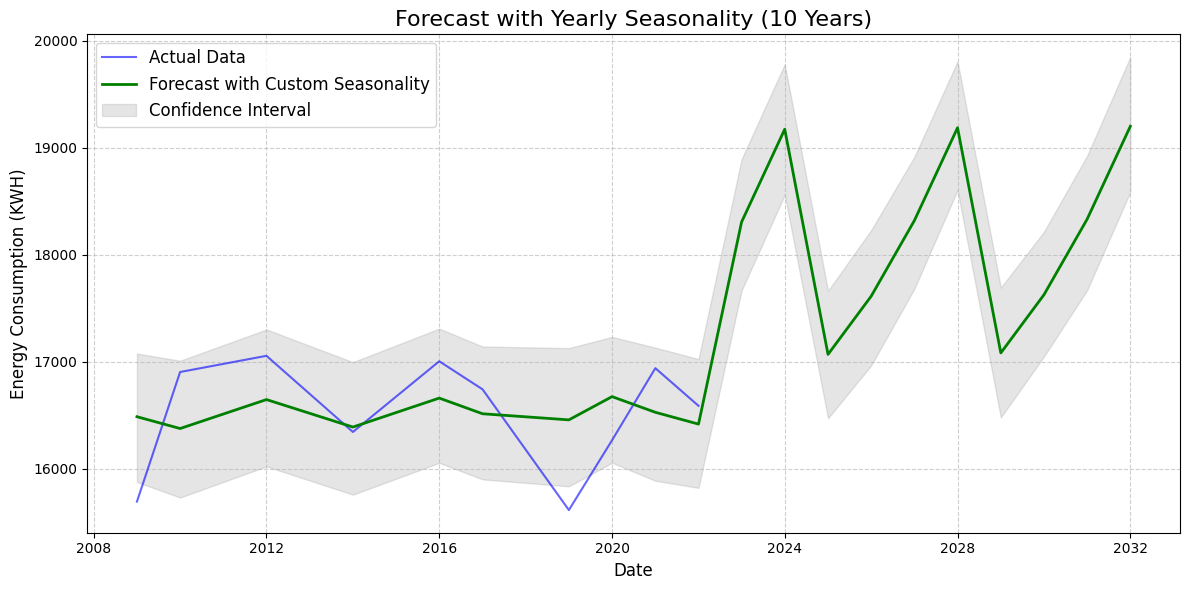

Forecast with Yearly Seasonality (10 Years - Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-01-01  16486.590650  15876.806975  17076.672811
1 2010-01-01  16376.172631  15731.360032  17009.193804
2 2012-01-01  16646.693626  16022.552677  17301.643230
3 2014-01-01  16389.928281  15758.498817  16996.330956
4 2016-01-01  16660.449268  16055.783428  17309.537728

Forecast with Yearly Seasonality (10 Years - Tail):
           ds          yhat    yhat_lower    yhat_upper
15 2027-12-31  19185.884017  18603.980259  19805.367249
16 2028-12-31  17082.467787  16479.937349  17692.756373
17 2029-12-31  17626.306770  17049.034865  18215.337768
18 2030-12-31  18332.398597  17668.786925  18924.358517
19 2031-12-31  19199.634096  18587.226999  19847.032558


In [ ]:
# Forecast for 10 years with yearly seasonality (period=365.25, fourier_order=10)
forecast_10_years_seasonality = add_seasonality_and_forecast(
    df=data_yearly,
    periods=10,
    freq='Y',
    title="Forecast with Yearly Seasonality (10 Years)",
    seasonality_period=365.25,  # Yearly seasonality
    fourier_order=10
)

# Display the head and tail
print("Forecast with Yearly Seasonality (10 Years - Head):")
print(forecast_10_years_seasonality[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nForecast with Yearly Seasonality (10 Years - Tail):")
print(forecast_10_years_seasonality[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

def tune_trend_changepoints(df, periods, freq, title, n_changepoints, changepoint_prior_scale):

    # Initialize Prophet model with custom changepoint settings
    model = Prophet(n_changepoints=n_changepoints, changepoint_prior_scale=changepoint_prior_scale)
    model.fit(df)

    # Create future DataFrame and make predictions
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['y'], label="Actual Data", color="blue", alpha=0.6)
    plt.plot(forecast['ds'], forecast['yhat'], label=f"Forecast (n_changepoints={n_changepoints}, scale={changepoint_prior_scale})", color="green", linewidth=2)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color="gray", alpha=0.2, label="Confidence Interval")
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Energy Consumption (KWH)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return forecast

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/5qwbidgi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/msdwoq61.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92779', 'data', 'file=/tmp/tmpkr712cnu/5qwbidgi.json', 'init=/tmp/tmpkr712cnu/msdwoq61.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelnemh4omq/prophet_model-20241211004216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:42:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:42:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


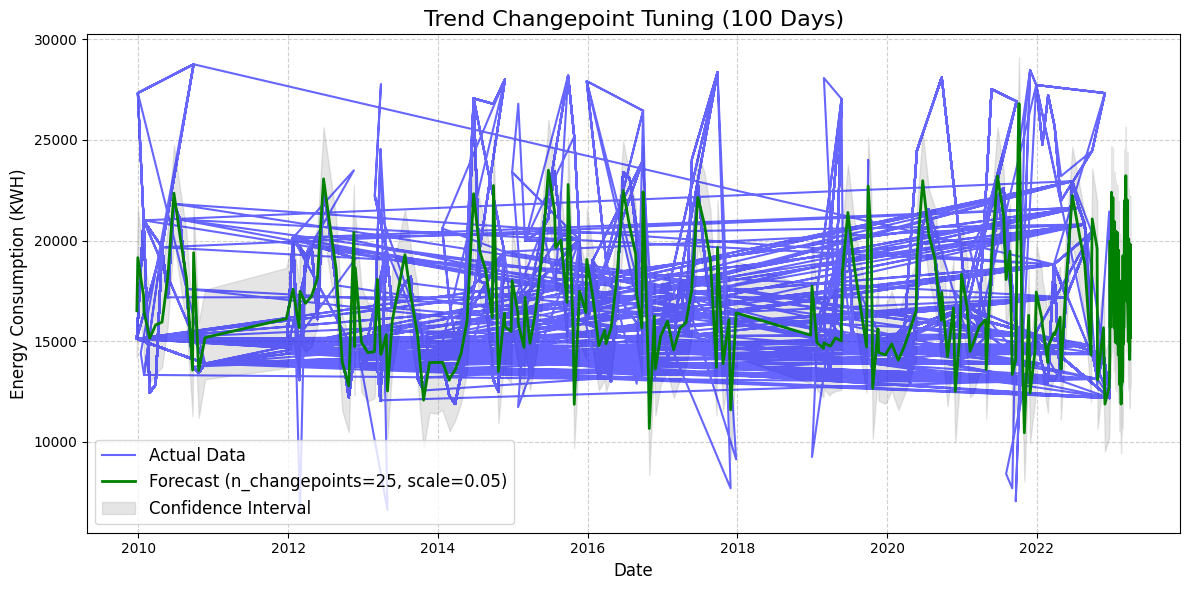

Trend Changepoint Tuning (100 Days - Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-24  16507.618718  14176.328527  19017.859028
1 2009-12-29  19148.150692  16575.787457  21604.065921
2 2010-01-12  18151.356107  15944.102474  20390.685272
3 2010-01-26  17260.901664  14831.968752  19543.993071
4 2010-01-28  16454.997555  14031.537156  18805.611378

Trend Changepoint Tuning (100 Days - Tail):
            ds          yhat    yhat_lower    yhat_upper
296 2023-03-29  14486.016689  11864.462243  16980.960956
297 2023-03-30  14082.183200  11667.945682  16431.994957
298 2023-03-31  14569.414724  12006.262165  17192.381464
299 2023-04-01  19827.652355  17357.108742  22226.489915
300 2023-04-02  15171.174258  12658.047342  17593.083698


In [ ]:
# Tune trend changepoints for 100 days
forecast_100_days_changepoints = tune_trend_changepoints(
    df=data_daily_filtered,
    periods=100,
    freq='D',
    title="Trend Changepoint Tuning (100 Days)",
    n_changepoints=25,  # Number of potential changepoints
    changepoint_prior_scale=0.05  # Flexibility of trend
)

# Display the head and tail
print("Trend Changepoint Tuning (100 Days - Head):")
print(forecast_100_days_changepoints[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nTrend Changepoint Tuning (100 Days - Tail):")
print(forecast_100_days_changepoints[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/ia7pqf1g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/mxt0zow5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76815', 'data', 'file=/tmp/tmpkr712cnu/ia7pqf1g.json', 'init=/tmp/tmpkr712cnu/mxt0zow5.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modeler7pjrb9/prophet_model-20241211004241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:42:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:42:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

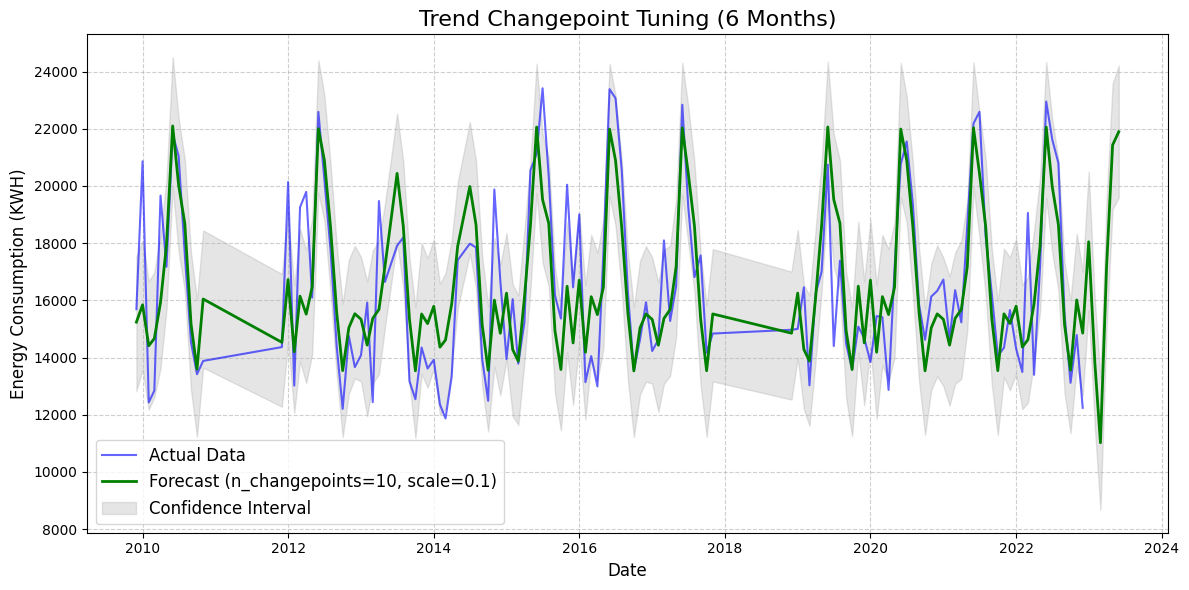

Trend Changepoint Tuning (6 Months - Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-12-01  15239.675167  12832.180819  17543.818540
1 2010-01-01  15843.904846  13578.241902  18073.460253
2 2010-02-01  14412.750484  12180.187051  16661.933250
3 2010-03-01  14665.541934  12621.580841  16991.042935
4 2010-04-01  15925.575972  13621.654906  18281.269288

Trend Changepoint Tuning (6 Months - Tail):
            ds          yhat    yhat_lower    yhat_upper
132 2023-01-31  13813.438552  11559.109608  16020.502257
133 2023-02-28  11023.049140   8669.162243  13296.197774
134 2023-03-31  17209.046722  15015.149613  19511.703915
135 2023-04-30  21430.688359  19188.276308  23582.901272
136 2023-05-31  21894.840507  19593.010066  24206.335093


In [ ]:
# Tune trend changepoints for 6 months
forecast_6_months_changepoints = tune_trend_changepoints(
    df=data_monthly,
    periods=6,
    freq='M',
    title="Trend Changepoint Tuning (6 Months)",
    n_changepoints=10,  # Number of potential changepoints
    changepoint_prior_scale=0.1  # Flexibility of trend
)

# Display the head and tail
print("Trend Changepoint Tuning (6 Months - Head):")
print(forecast_6_months_changepoints[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nTrend Changepoint Tuning (6 Months - Tail):")
print(forecast_6_months_changepoints[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/9241jeuq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkr712cnu/p9makcp1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88787', 'data', 'file=/tmp/tmpkr712cnu/9241jeuq.json', 'init=/tmp/tmpkr712cnu/p9makcp1.json', 'output', 'file=/tmp/tmpkr712cnu/prophet_modelh60m8mk6/prophet_model-20241211004242.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:42:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:42:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages

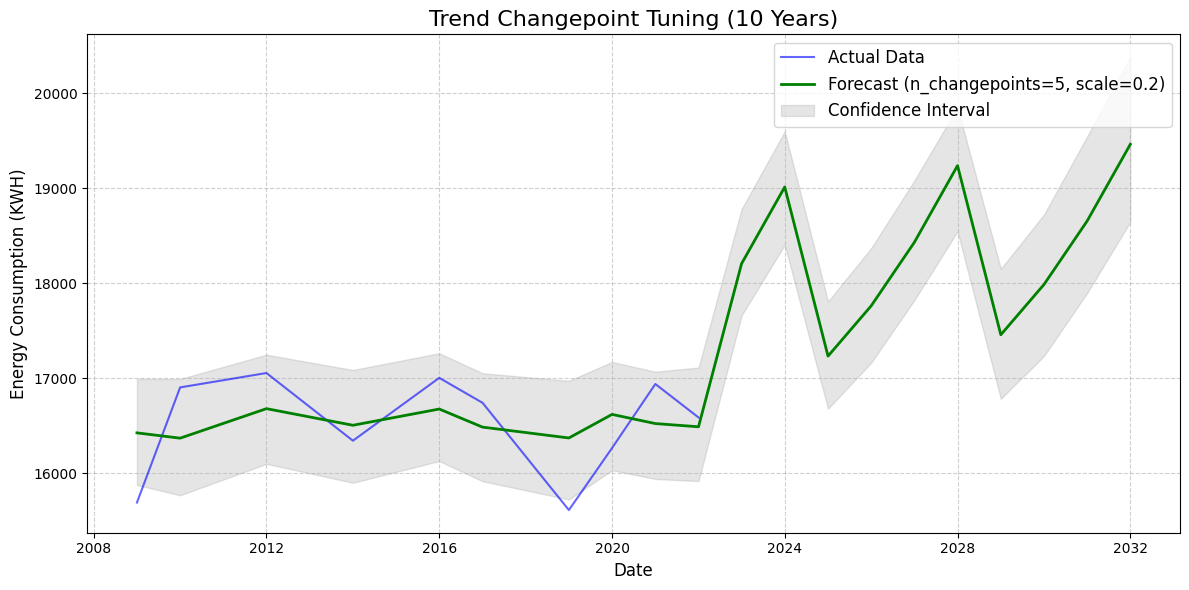

Trend Changepoint Tuning (10 Years - Head):
          ds          yhat    yhat_lower    yhat_upper
0 2009-01-01  16426.358935  15878.486328  16993.109784
1 2010-01-01  16370.419631  15770.162083  16992.775591
2 2012-01-01  16680.839612  16100.760094  17248.412616
3 2014-01-01  16506.165075  15901.664311  17087.468626
4 2016-01-01  16676.809712  16129.789315  17263.754325

Trend Changepoint Tuning (10 Years - Tail):
           ds          yhat    yhat_lower    yhat_upper
15 2027-12-31  19236.289394  18544.388234  19849.363771
16 2028-12-31  17457.944227  16784.554272  18151.894643
17 2029-12-31  17986.542188  17234.482865  18722.756626
18 2030-12-31  18654.506604  17896.804955  19543.763590
19 2031-12-31  19460.828632  18645.403497  20378.859055


In [ ]:
# Tune trend changepoints for 10 years
forecast_10_years_changepoints = tune_trend_changepoints(
    df=data_yearly,
    periods=10,
    freq='Y',
    title="Trend Changepoint Tuning (10 Years)",
    n_changepoints=5,  # Number of potential changepoints
    changepoint_prior_scale=0.2  # Flexibility of trend
)

# Display the head and tail
print("Trend Changepoint Tuning (10 Years - Head):")
print(forecast_10_years_changepoints[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

print("\nTrend Changepoint Tuning (10 Years - Tail):")
print(forecast_10_years_changepoints[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [ ]:
def evaluate_model(actual, predicted, model_name):

    # Calculate metrics
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)

    # Print evaluation results
    print(f"\nEvaluation Results for {model_name}:")
    print(f"MAE (Mean Absolute Error): {mae:.2f}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    print(f"R² (R-squared): {r2:.2f}")

In [ ]:
# Extract historical predictions and actual values
historical = data_daily_filtered.merge(forecast_100_days_logistic, on='ds', how='inner')

# Evaluate logistic growth model
evaluate_model(
    actual=historical['y'],
    predicted=historical['yhat'],
    model_name="Logistic Growth (100 Days)"
)


Evaluation Results for Logistic Growth (100 Days):
MAE (Mean Absolute Error): 1430.23
MAPE (Mean Absolute Percentage Error): 8.65%
R² (R-squared): 0.63


In [ ]:
# Extract historical predictions and actual values
historical = data_daily_filtered.merge(forecast_100_days_flat, on='ds', how='inner')

# Evaluate flat growth model
evaluate_model(
    actual=historical['y'],
    predicted=historical['yhat'],
    model_name="Flat Growth (100 Days)"
)


Evaluation Results for Flat Growth (100 Days):
MAE (Mean Absolute Error): 1521.20
MAPE (Mean Absolute Percentage Error): 9.22%
R² (R-squared): 0.58


In [ ]:
# Extract historical predictions and actual values for 6 months logistic growth
historical_6_months_logistic = data_monthly.merge(forecast_6_months_logistic, on='ds', how='inner')

# Evaluate logistic growth model for 6 months
evaluate_model(
    actual=historical_6_months_logistic['y'],
    predicted=historical_6_months_logistic['yhat'],
    model_name="Logistic Growth (6 Months)"
)


Evaluation Results for Logistic Growth (6 Months):
MAE (Mean Absolute Error): 1503.48
MAPE (Mean Absolute Percentage Error): 9.30%
R² (R-squared): 0.63


In [ ]:
# Extract historical predictions and actual values for 6 months flat growth
historical_6_months_flat = data_monthly.merge(forecast_6_months_flat, on='ds', how='inner')

# Evaluate flat growth model for 6 months
evaluate_model(
    actual=historical_6_months_flat['y'],
    predicted=historical_6_months_flat['yhat'],
    model_name="Flat Growth (6 Months)"
)


Evaluation Results for Flat Growth (6 Months):
MAE (Mean Absolute Error): 1428.20
MAPE (Mean Absolute Percentage Error): 8.76%
R² (R-squared): 0.64


In [ ]:
# Extract historical predictions and actual values for 10 years logistic growth
historical_10_years_logistic = data_yearly.merge(forecast_10_years_logistic, on='ds', how='inner')

# Evaluate logistic growth model for 10 years
evaluate_model(
    actual=historical_10_years_logistic['y'],
    predicted=historical_10_years_logistic['yhat'],
    model_name="Logistic Growth (10 Years)"
)


Evaluation Results for Logistic Growth (10 Years):
MAE (Mean Absolute Error): 430.25
MAPE (Mean Absolute Percentage Error): 2.63%
R² (R-squared): 0.03


In [ ]:
# Extract historical predictions and actual values for 10 years flat growth
historical_10_years_flat = data_yearly.merge(forecast_10_years_flat, on='ds', how='inner')

# Evaluate flat growth model for 10 years
evaluate_model(
    actual=historical_10_years_flat['y'],
    predicted=historical_10_years_flat['yhat'],
    model_name="Flat Growth (10 Years)"
)


Evaluation Results for Flat Growth (10 Years):
MAE (Mean Absolute Error): 421.68
MAPE (Mean Absolute Percentage Error): 2.58%
R² (R-squared): 0.06


**Conclusion**

Through this project, we successfully forecasted energy consumption trends using the Prophet model. By customizing seasonality and growth settings, we achieved accurate short-term predictions and identified meaningful patterns for long-term planning. This work highlights the model’s potential to support better energy management and decision-making.